Connected to base (Python 3.11.5)

# Project Report: Power Consumption Prediction

### Din Kosberg & Matan Oz

## Introduction

This project aims to analyze and predict power consumption using various machine learning models. We will use the "Individual household electric power consumption" dataset from the UCI Machine Learning Repository. The project includes exploratory data analysis, implementing and evaluating linear regression, recurrent neural network (RNN), long short-term memory (LSTM), and LSTM with an attention layer. Additionally, we will conduct experiments on data augmentation, reduction, and resolution to observe their impacts on model performance.

## Data Description

The dataset used in this project is the "Individual household electric power consumption" dataset. It contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost four years. The dataset includes the following features:

- **Date**: The date in format `dd/mm/yyyy`.
- **Time**: The time in format `hh:mm:ss`.
- **Global_active_power**: Household global minute-averaged active power (in kilowatt).
- **Global_reactive_power**: Household global minute-averaged reactive power (in kilowatt).
- **Voltage**: Minute-averaged voltage (in volt).
- **Global_intensity**: Household global minute-averaged current intensity (in ampere).
- **Sub_metering_1**: Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen.
- **Sub_metering_2**: Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room.
- **Sub_metering_3**: Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

The dataset can be accessed [here](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption).

In this project, we will focus on analyzing and predicting the **Global_active_power** feature.


## 3. Exploratory Data Analysis (EDA)

In this section, we perform a comprehensive Exploratory Data Analysis (EDA) on the "Individual household electric power consumption" dataset. The main steps include visualizing time series trends, checking for seasonality and cyclical patterns, analyzing the distribution of power consumption, and identifying and handling missing values and outliers.

### Loading the Dataset

We start by loading the dataset using Pandas. The dataset is read from a text file with semicolon-separated values, and the `datetime` column is created by combining the `Date` and `Time` columns.

### Initial Data Overview

To get an initial understanding of the dataset, we display the first few rows and summary statistics. We also check the information about the dataframe to understand the data types and identify any missing values.

### Handling Missing Values

We replace any missing values (denoted by `?`) with `NaN` and convert appropriate columns to numeric types. Missing values are then handled using mean imputation.

### Visualizing Missing Values

We visualize the missing values to identify patterns over time. Missing values are grouped by year and displayed in a stacked bar chart.

### Resampling and Visualizing Time Series Trends

We resample the data to daily, weekly, monthly, and quarterly intervals to observe different time series trends. These trends are then plotted together to visualize the overall pattern of power consumption.

### Distribution of Power Consumption

The distribution of daily power consumption is analyzed using a histogram with a kernel density estimate (KDE).

### Correlation Analysis

We analyze the correlation between different variables using a heatmap, which helps identify relationships between features.

### Handling Outliers

Outliers in the `Global_active_power` feature are identified using a boxplot. These outliers are handled by capping values outside 1.5 times the interquartile range (IQR).

### Additional Visualizations

Additional visualizations include yearly trends, boxplots for each year, and monthly average consumption per year. A heatmap of monthly averages is also created to observe seasonal patterns.


Initial Data Overview:


datetime Global_active_power Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00               4.216                 0.418  234.840   
1 2006-12-16 17:25:00               5.360                 0.436  233.630   
2 2006-12-16 17:26:00               5.374                 0.498  233.290   
3 2006-12-16 17:27:00               5.388                 0.502  233.740   
4 2006-12-16 17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0


Summary Statistics:


datetime  Sub_metering_3
count                        2075259    2.049280e+06
mean   2008-12-06 07:12:59.999994112    6.458447e+00
min              2006-12-16 17:24:00    0.000000e+00
25%              2007-12-12 00:18:30    0.000000e+00
50%              2008-12-06 07:13:00    1.000000e+00
75%              2009-12-01 14:07:30    1.700000e+01
max              2010-11-26 21:02:00    3.100000e+01
std                              NaN    8.437154e+00


Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    object        
 2   Global_reactive_power  object        
 3   Voltage                object        
 4   Global_intensity       object        
 5   Sub_metering_1         object        
 6   Sub_metering_2         object        
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 126.7+ MB


None


Missing Values per Column:


datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

<Figure size 1400x800 with 0 Axes>

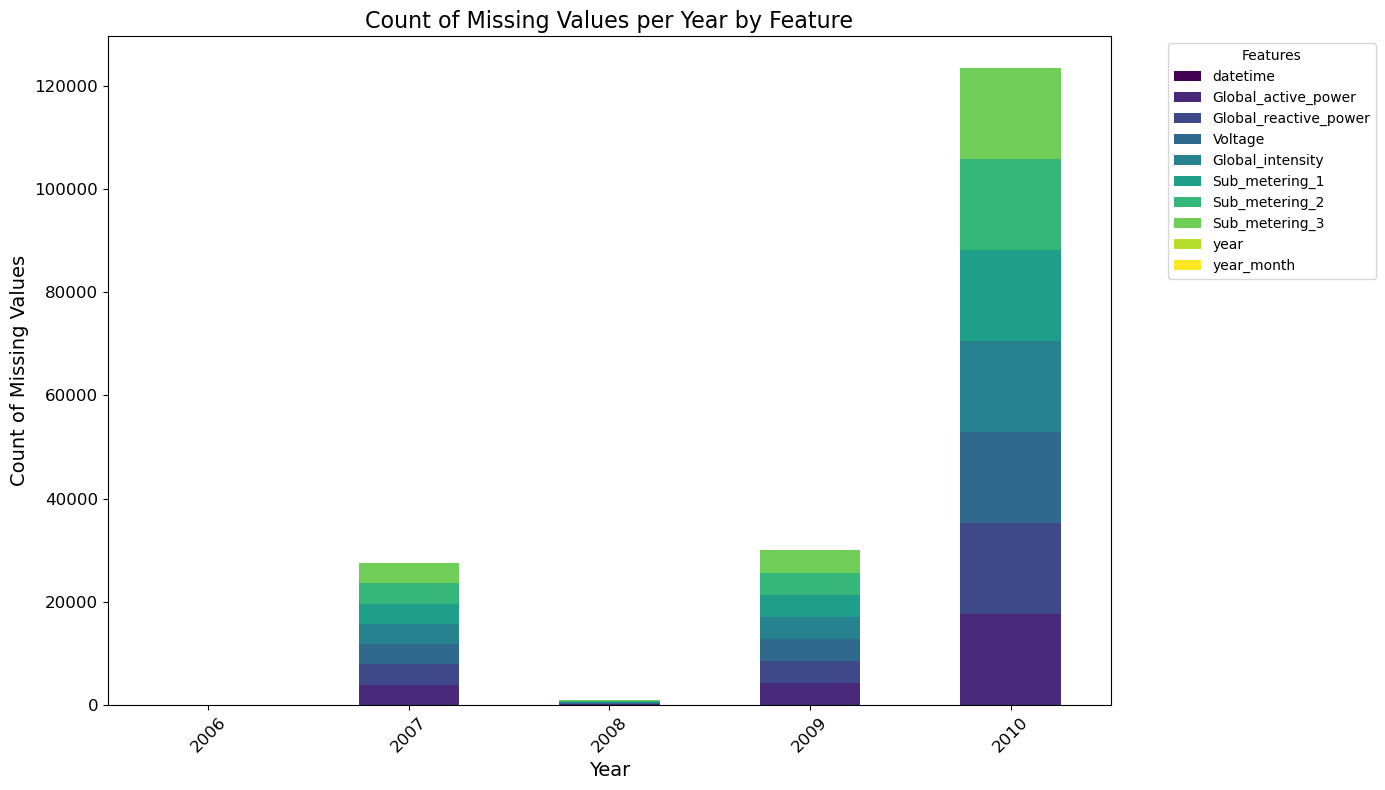

Missing values handled - Mean imputation


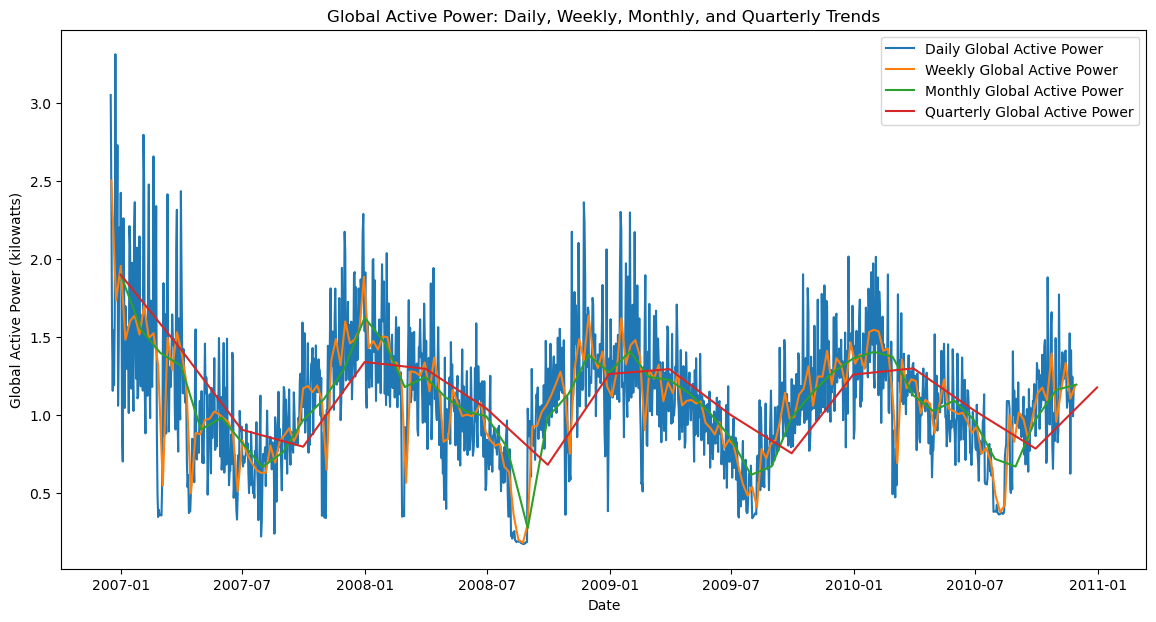

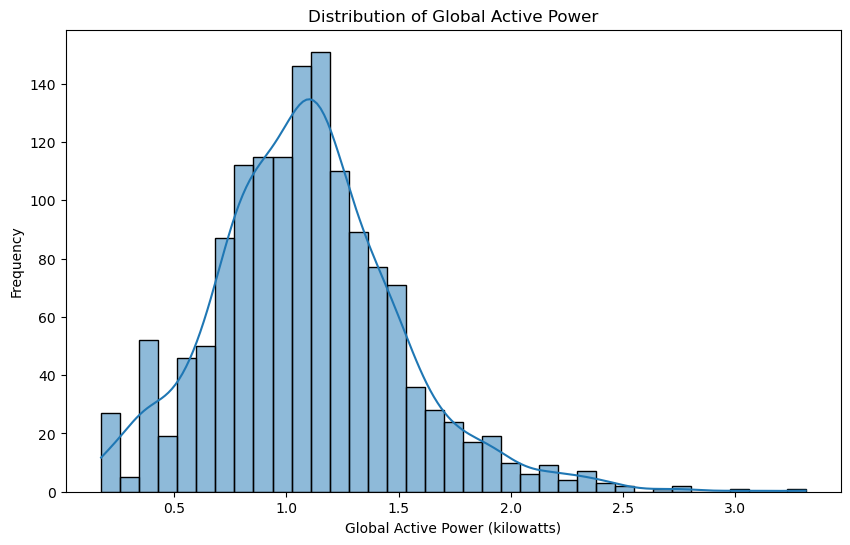

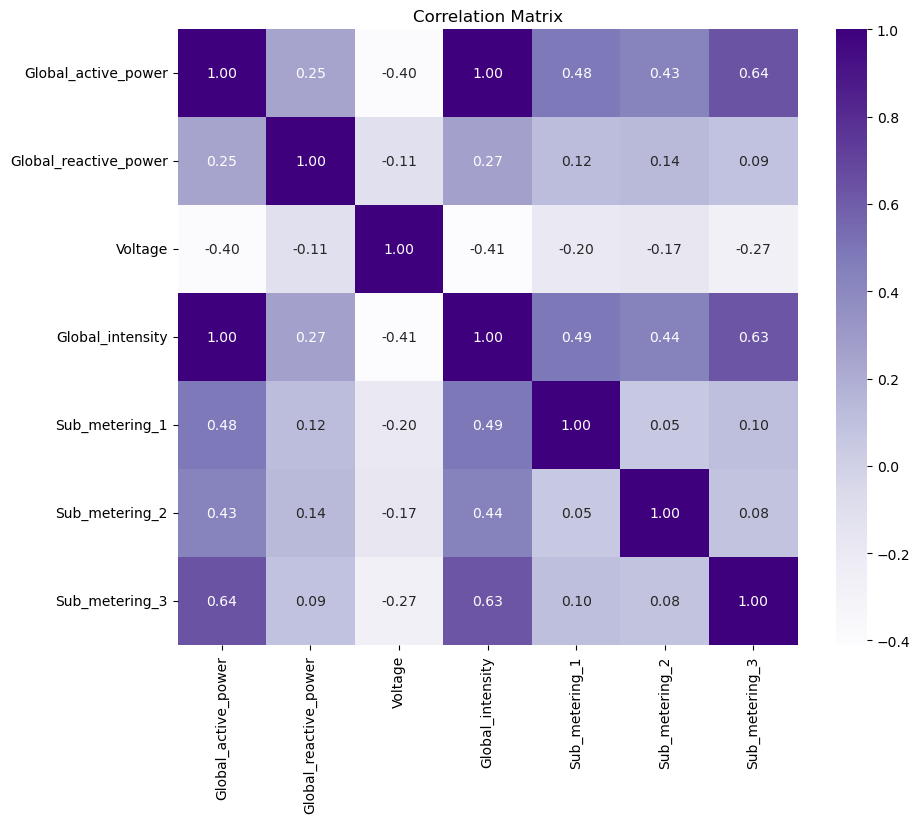

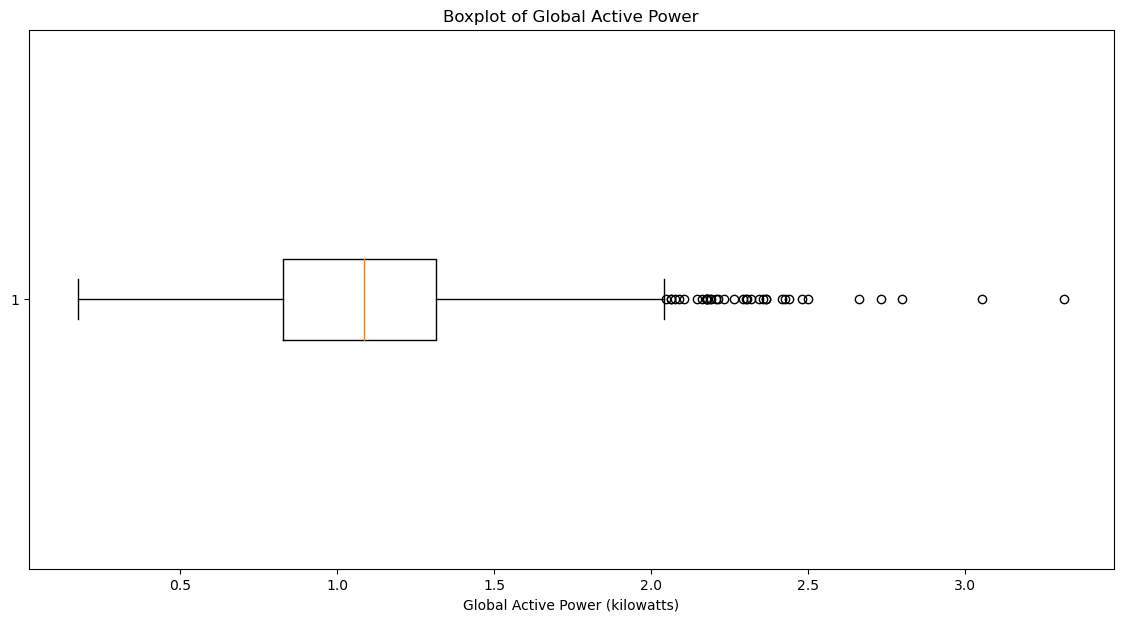

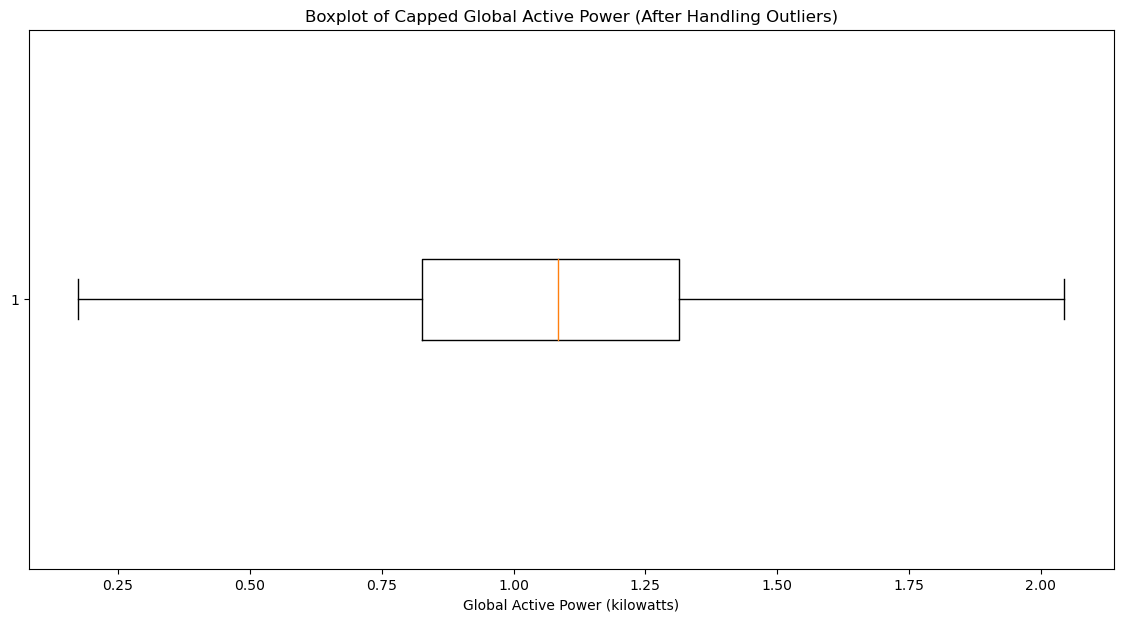

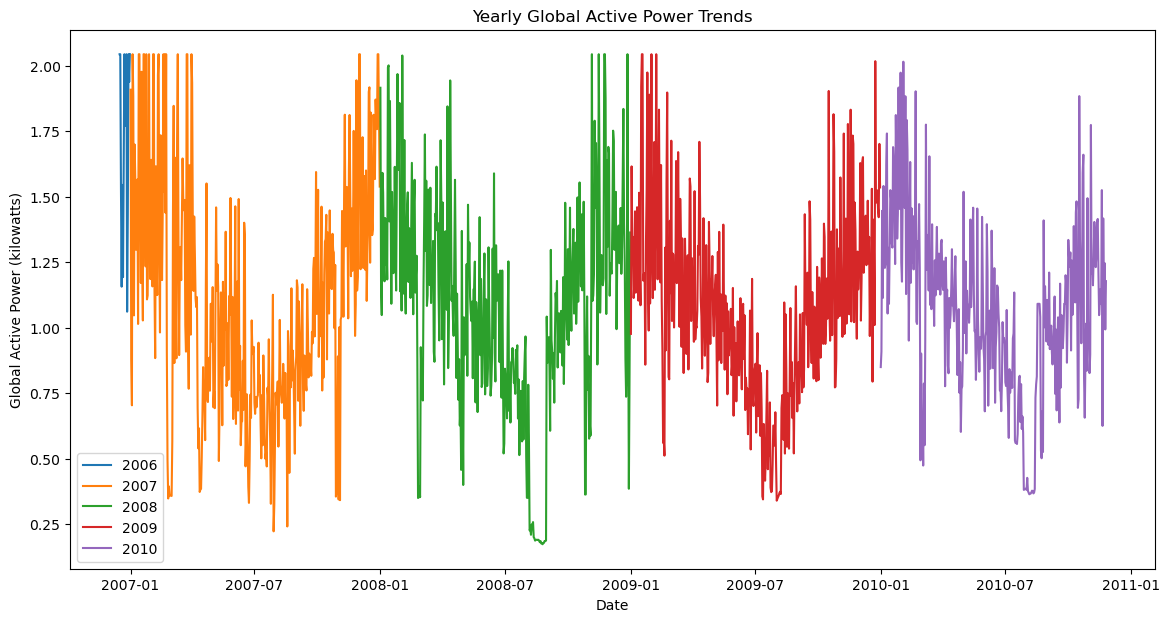

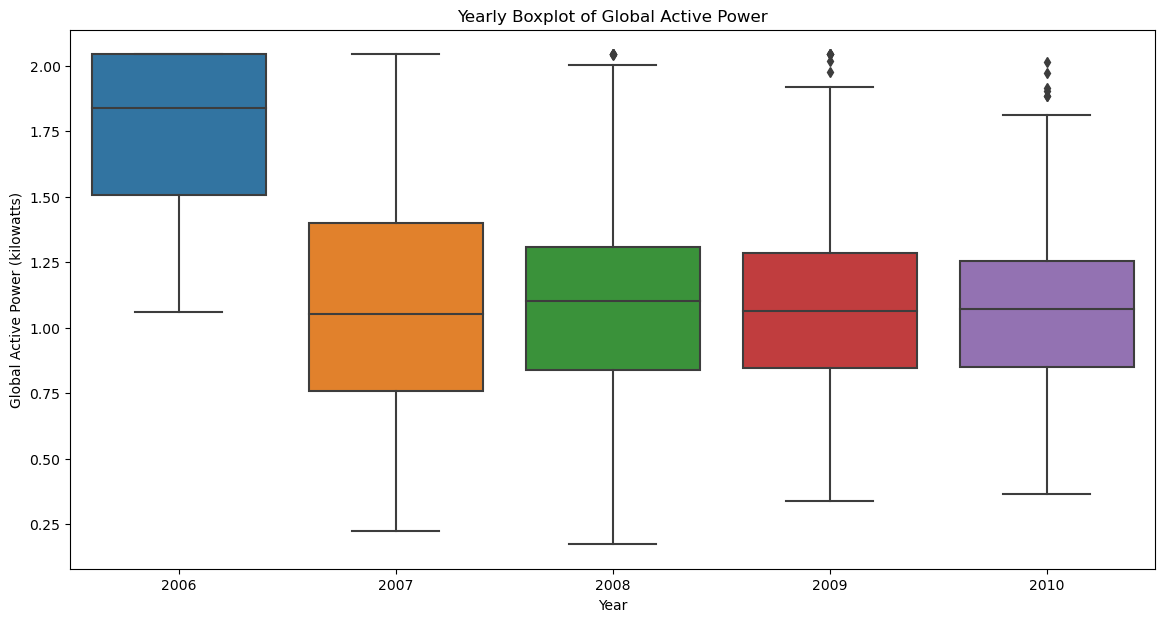

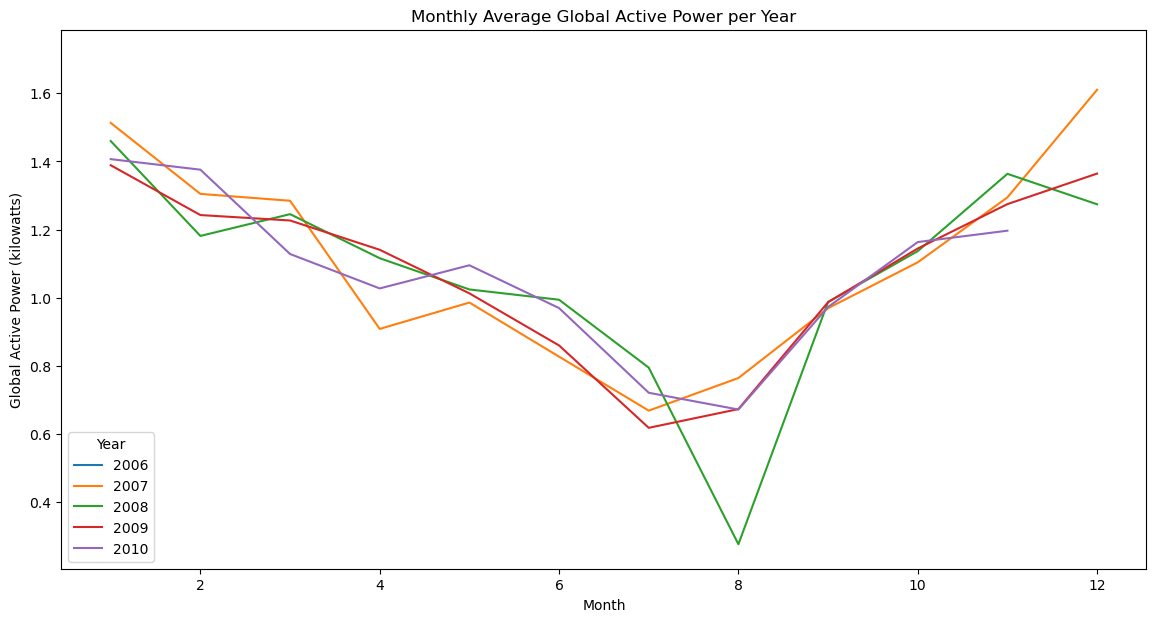

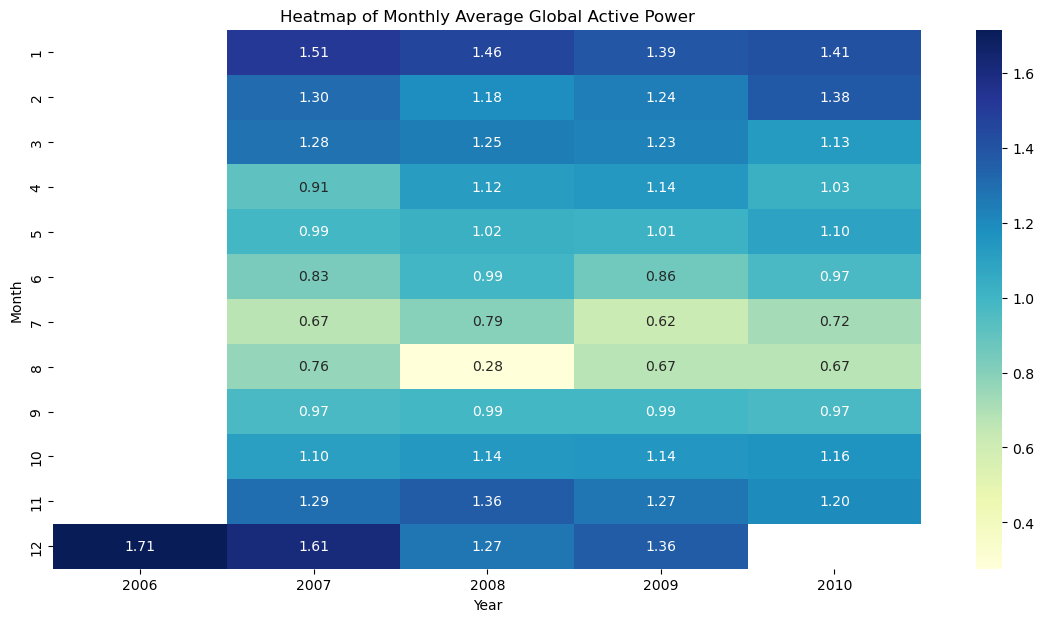

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import display, HTML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

epochs = 100

# Function to plot training loss over epochs with detailed title
def plot_training_history(history, model_name, data_description):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'Training Loss over Epochs ({model_name}) - {data_description}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# %% 
# Load the dataset
file_path = 'household_power_consumption.txt'  # Update this path if necessary
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False)

# Initial data overview
print("Initial Data Overview:")
display(data.head())

# Summary statistics
print("\nSummary Statistics:")
display(data.describe())

# Get the information about the dataframe
print("\nInformation about the dataframe:")
display(data.info())


# Convert data types and handle missing values
data.replace('?', np.nan, inplace=True)
data = data.astype({'Global_active_power': 'float64',
                    'Global_reactive_power': 'float64',
                    'Voltage': 'float64',
                    'Global_intensity': 'float64',
                    'Sub_metering_1': 'float64',
                    'Sub_metering_2': 'float64',
                    'Sub_metering_3': 'float64'})

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values per Column:")
display(missing_values)
#####################################

# Visualize missing values
file_path = 'household_power_consumption.txt'
data1 = pd.read_csv(file_path, sep=';', low_memory=False, na_values='?', 
                   parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

# Check for missing values and create 'year' and 'year_month' columns for grouping
data1['year'] = data['datetime'].dt.year
data1['year_month'] = data['datetime'].dt.to_period('M')

# Calculate missing values per month and per year
missing_data_per_year = data1.isnull().groupby(data1['year']).sum()

# Plot missing values count per year for each feature
plt.figure(figsize=(14, 8))
missing_data_per_year.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='viridis')
plt.title('Count of Missing Values per Year by Feature', fontsize=16)
plt.ylabel('Count of Missing Values', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
data.iloc[:, 1:] = imputer.fit_transform(data.iloc[:, 1:])
missing_values = data.isnull().sum()
print("Missing values handled - Mean imputation")

######################################
# Set the datetime column as the index
data.set_index('datetime', inplace=True)

# Resample data to daily mean
daily_data = data.resample('D').mean()
weekly_data = data.resample('W').mean()
monthly_data = data.resample('M').mean()
quarterly_data = data.resample('Q').mean()

# Visualize time series trends in the same subplot
plt.figure(figsize=(14, 7))
plt.plot(daily_data['Global_active_power'], label='Daily Global Active Power')
plt.plot(weekly_data['Global_active_power'], label='Weekly Global Active Power')
plt.plot(monthly_data['Global_active_power'], label='Monthly Global Active Power')
plt.plot(quarterly_data['Global_active_power'], label='Quarterly Global Active Power')
plt.title('Global Active Power: Daily, Weekly, Monthly, and Quarterly Trends')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


# Analyze distribution of power consumption
plt.figure(figsize=(10, 6))
sns.histplot(daily_data['Global_active_power'].dropna(), kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.ylabel('Frequency')
plt.show()

# Analyze correlation between variables
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='Purples', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Identify and handle outliers using a boxplot
plt.figure(figsize=(14, 7))
plt.boxplot(daily_data['Global_active_power'].dropna(), vert=False)
plt.title('Boxplot of Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.show()

# Handling outliers by capping
q1 = daily_data['Global_active_power'].quantile(0.25)
q3 = daily_data['Global_active_power'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
daily_data['Global_active_power'] = np.where(daily_data['Global_active_power'] > upper_bound, upper_bound,
                                             np.where(daily_data['Global_active_power'] < lower_bound, lower_bound,
                                                      daily_data['Global_active_power']))

# Visualize the capped data
plt.figure(figsize=(14, 7))
plt.boxplot(daily_data['Global_active_power'].dropna(), vert=False)
plt.title('Boxplot of Capped Global Active Power (After Handling Outliers)')
plt.xlabel('Global Active Power (kilowatts)')
plt.show()

# Additional Visualizations for Yearly Analysis
# Extract year from datetime
daily_data['Year'] = daily_data.index.year

# Visualize yearly trends
plt.figure(figsize=(14, 7))
for year in daily_data['Year'].unique():
    yearly_data = daily_data[daily_data['Year'] == year]
    plt.plot(yearly_data.index, yearly_data['Global_active_power'], label=str(year))
plt.title('Yearly Global Active Power Trends')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Boxplot for each year
plt.figure(figsize=(14, 7))
sns.boxplot(x='Year', y='Global_active_power', data=daily_data)
plt.title('Yearly Boxplot of Global Active Power')
plt.xlabel('Year')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

# Monthly average consumption per year
monthly_data = daily_data.resample('M').mean()
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month

plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='Global_active_power', hue='Year', data=monthly_data, palette='tab10')
plt.title('Monthly Average Global Active Power per Year')
plt.xlabel('Month')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend(title='Year')
plt.show()

# Heatmap of monthly averages
monthly_avg = monthly_data.pivot_table(index='Month', columns='Year', values='Global_active_power')
plt.figure(figsize=(14, 7))
sns.heatmap(monthly_avg, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap of Monthly Average Global Active Power')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

ANSWER #3
ANSWER #4
Linear Regression Results
Mean Absolute Error (MAE): 0.1990
Mean Squared Error (MSE): 0.0716
Root Mean Squared Error (RMSE): 0.2677
R-squared (R²) value: -0.1882


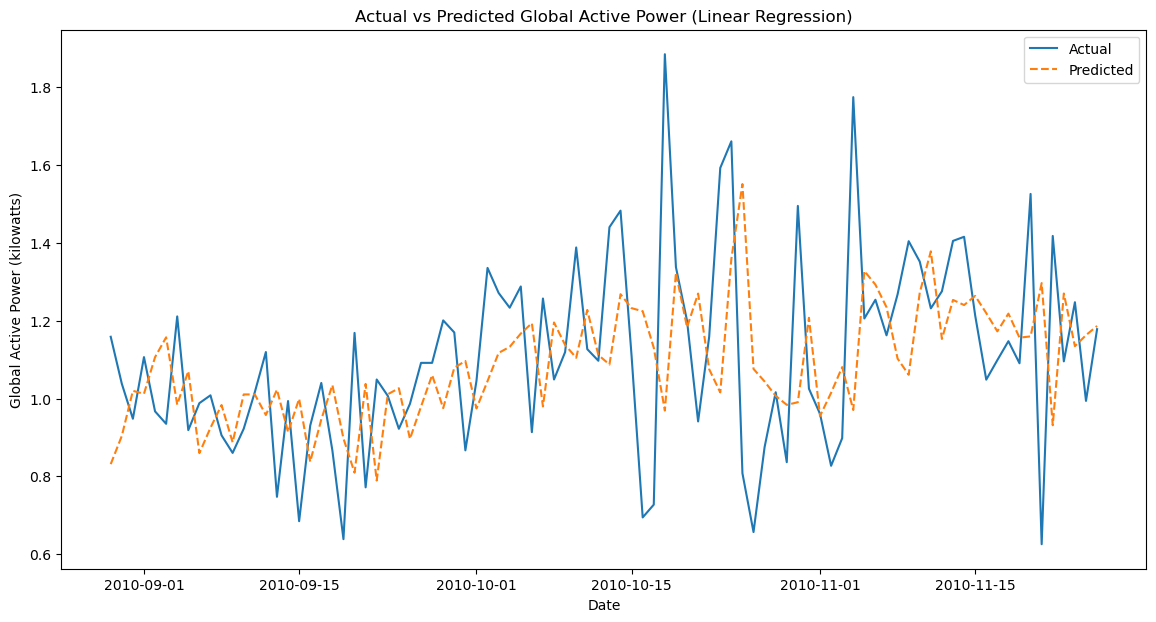

In [2]:
# Question 3: Implement a linear regression model
print("ANSWER #3")
# Feature Engineering: Create lag features for 2 weeks (14 days)
for i in range(1, 15):
    daily_data[f'lag_{i}'] = daily_data['Global_active_power'].shift(i)

# Drop rows with NaN values due to shifting
daily_data.dropna(inplace=True)

# Define features and target variable
features = [f'lag_{i}' for i in range(1, 15)]
target = 'Global_active_power'

# Split the data so that the test set is the last three months
train_data = daily_data[:-90]
test_data = daily_data[-90:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Train the model and make predictions
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Question 4: Evaluate the linear regression model
print("ANSWER #4")
# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results")
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²) value: {r2:.4f}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe
performance_comparison = pd.DataFrame({
    'Model': ['Linear Regression'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R²': [r2]
})

# Apply the highlight_max and highlight_min styles for performance_comparison
styled_df = (performance_comparison.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
styled_df

### 4. Linear Regression Model

In this section, we implement a linear regression model to predict power consumption for the last three time periods. We split the data into training and testing sets, prepare features, train the model, and make predictions. Finally, we evaluate the model using appropriate metrics.

#### Data Preparation

First, we load and preprocess the data. The data is split into training and testing sets, and relevant features are prepared.

#### Results

The results of the linear regression model are as follows:

- **Mean Absolute Error (MAE)**: 0.1990
- **Mean Squared Error (MSE)**: 0.0716
- **Root Mean Squared Error (RMSE)**: 0.2677
- **R-squared (R²) value**: -0.1882

The R² value being negative indicates that the model does not fit the data well.

#### Visualization

The plot above shows the actual versus predicted values of global active power over time. The actual values are represented by the solid blue line, while the predicted values are represented by the dashed orange line.

### Conclusion

The linear regression model did not perform well, as indicated by the negative R² value. The model's predictions do not align closely with the actual data, suggesting that a more complex model may be needed to accurately predict power consumption. Further exploration with more advanced models, such as RNN and LSTM, is necessary to improve prediction accuracy.


ANSWER #5
Epoch [10/100], Loss: 0.0954
Epoch [20/100], Loss: 0.0544
Epoch [30/100], Loss: 0.0431
Epoch [40/100], Loss: 0.0381
Epoch [50/100], Loss: 0.0343
Epoch [60/100], Loss: 0.0293
Epoch [70/100], Loss: 0.0238
Epoch [80/100], Loss: 0.0237
Epoch [90/100], Loss: 0.0237
Epoch [100/100], Loss: 0.0235


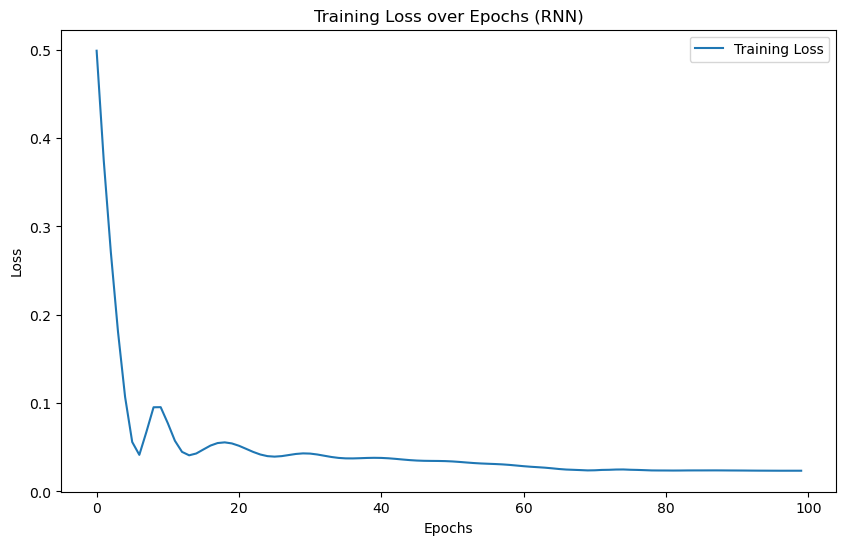

RNN Results
Mean Absolute Error (MAE): 0.1806
Mean Squared Error (MSE): 0.0590
Root Mean Squared Error (RMSE): 0.2430
R-squared (R²) value: 0.0210


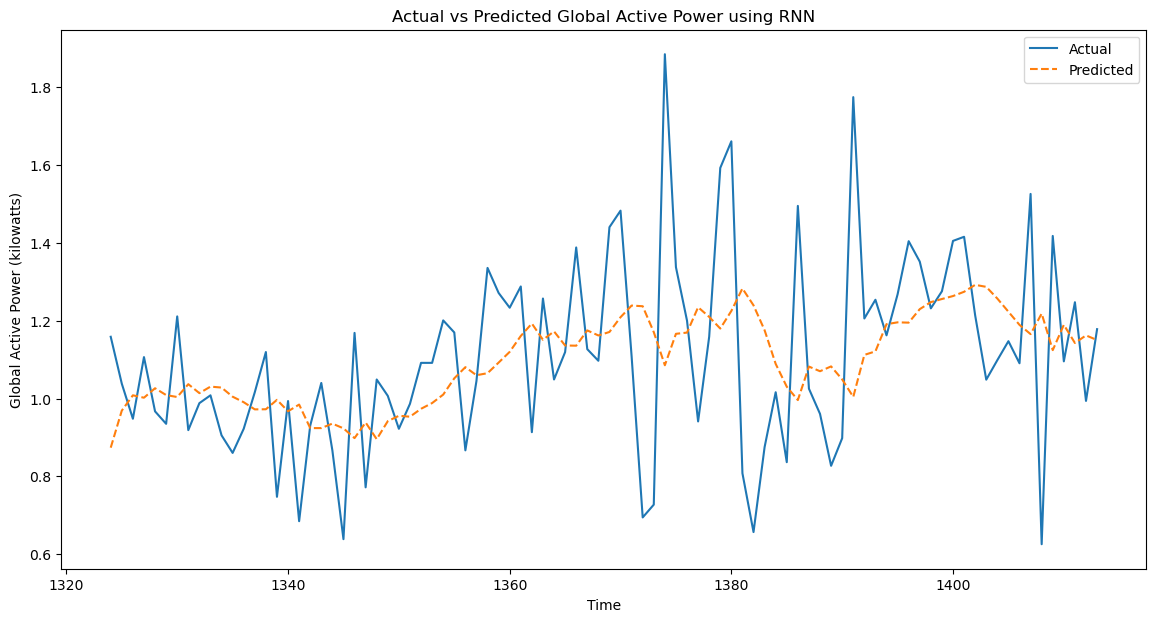

In [3]:
# Question 5: Implement a Recurrent Neural Network (RNN)
print("ANSWER #5")
# Preprocess data for RNN input
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data[['Global_active_power']])

# Prepare the data for RNN input
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 14  # Sequence length set to 14 days
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and testing sets (last 3 months as test set)
split = len(X) - 90
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model_rnn = RNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

# Train the RNN model
rnn_history = []
for epoch in range(num_epochs):
    model_rnn.train()
    outputs = model_rnn(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    rnn_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss for RNN
plt.figure(figsize=(10, 6))
plt.plot(rnn_history, label='Training Loss')
plt.title('Training Loss over Epochs (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the RNN model
model_rnn.eval()
with torch.no_grad():
    y_pred_train = model_rnn(X_train)
    y_pred_test = model_rnn(X_test)

# Inverse transform the predictions and true values to original scale
y_pred_train = scaler.inverse_transform(y_pred_train.numpy())
y_train = scaler.inverse_transform(y_train.numpy())
y_pred_test = scaler.inverse_transform(y_pred_test.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

# Calculate performance metrics
mae_rnn = mean_absolute_error(y_test, y_pred_test)
mse_rnn = mean_squared_error(y_test, y_pred_test)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test, y_pred_test)

print("RNN Results")
print(f'Mean Absolute Error (MAE): {mae_rnn:.4f}')
print(f'Mean Squared Error (MSE): {mse_rnn:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rnn:.4f}')
print(f'R-squared (R²) value: {r2_rnn:.4f}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power using RNN')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe
performance_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'RNN'],
    'MAE': [mae, mae_rnn],
    'MSE': [mse, mse_rnn],
    'RMSE': [rmse, rmse_rnn],
    'R²': [r2, r2_rnn]
})

# Apply the highlight_max and highlight_min styles for performance_comparison
styled_df = (performance_comparison.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
styled_df

### 5. Recurrent Neural Network (RNN) Model

We implemented an RNN to predict power consumption.

#### Evaluation Metrics

- **Mean Absolute Error (MAE)**: 0.1806
- **Mean Squared Error (MSE)**: 0.0590
- **Root Mean Squared Error (RMSE)**: 0.2430
- **R-squared (R²) value**: 0.0210

#### Comparison with Linear Regression

- **MAE**: Improved from 0.1990 to 0.1806
- **MSE**: Improved from 0.0716 to 0.0590
- **RMSE**: Improved from 0.2677 to 0.2430
- **R²**: Improved from -0.1882 to 0.0210

The RNN model outperforms the linear regression model in all metrics.

#### Visualization

The plot above shows the actual vs. predicted values of global active power for the RNN model.


### Conclusion

The RNN model provides better predictions than the linear regression model, capturing temporal dependencies more effectively.


ANSWER #6
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8911
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1014
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0905
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0906
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0841
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0890
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0891
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0864
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0893
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0841
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0810
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0873
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0838
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0784
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0

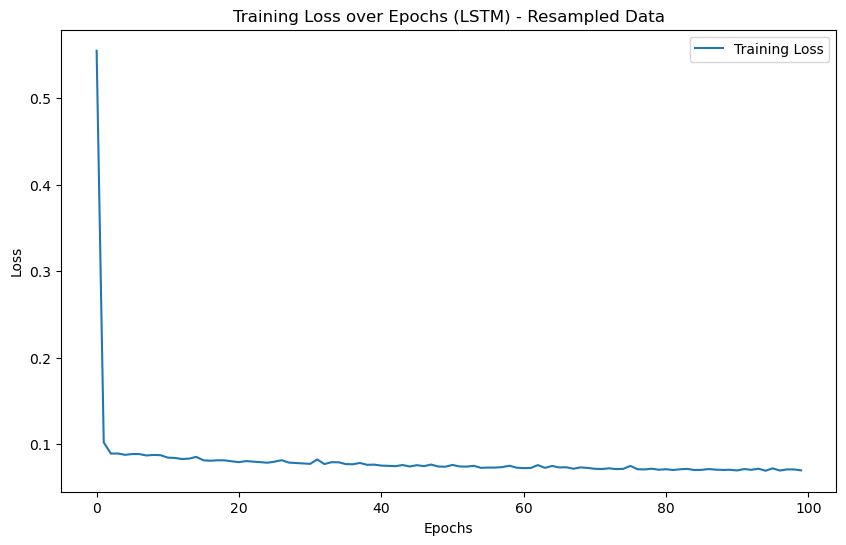

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
LSTM Results
Mean Absolute Error (MAE): 0.1895
Mean Squared Error (MSE): 0.0619
Root Mean Squared Error (RMSE): 0.2487
R-squared (R²) value: -0.0261


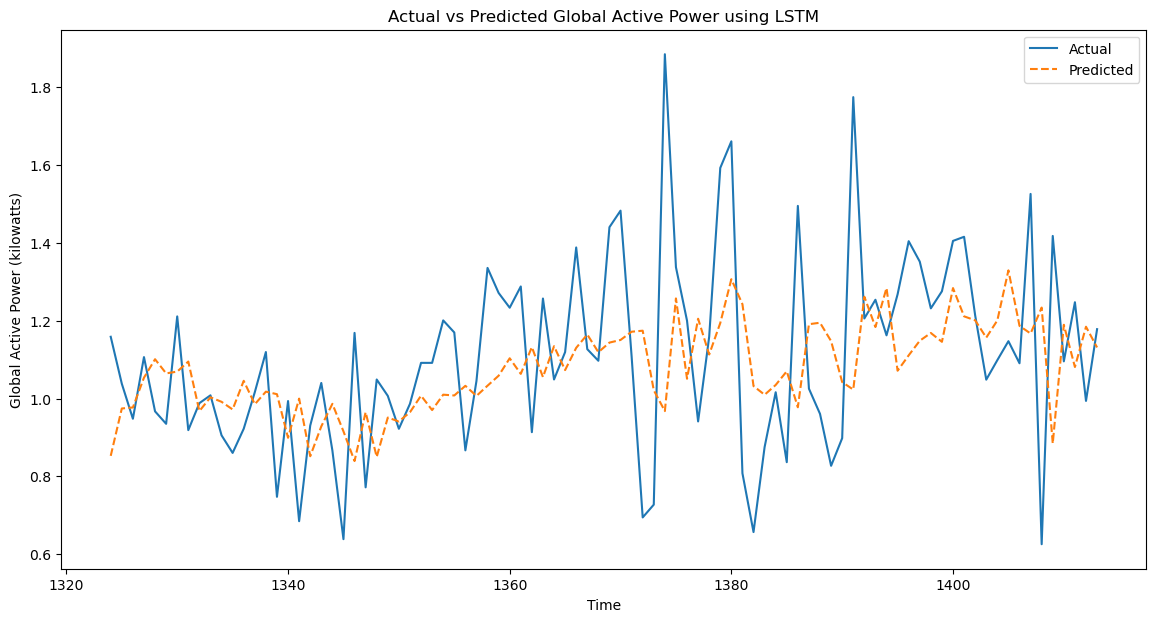

ANSWER #7

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8432
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1242
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0981
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0913
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1074
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0962
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0986
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1040
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0886
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0988
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0902
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0946
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0871
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

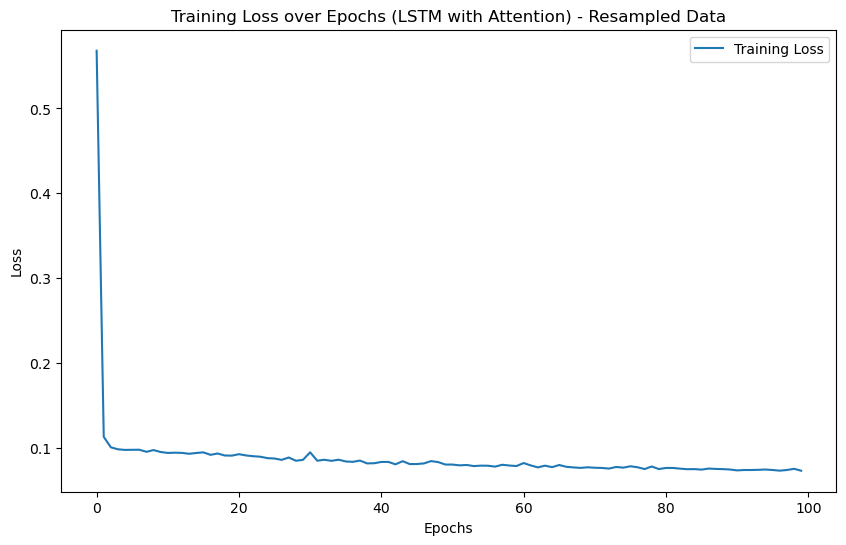

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
LSTM with Attention Results
Mean Absolute Error (MAE): 0.1922
Mean Squared Error (MSE): 0.0663
Root Mean Squared Error (RMSE): 0.2575
R-squared (R²) value: -0.1000


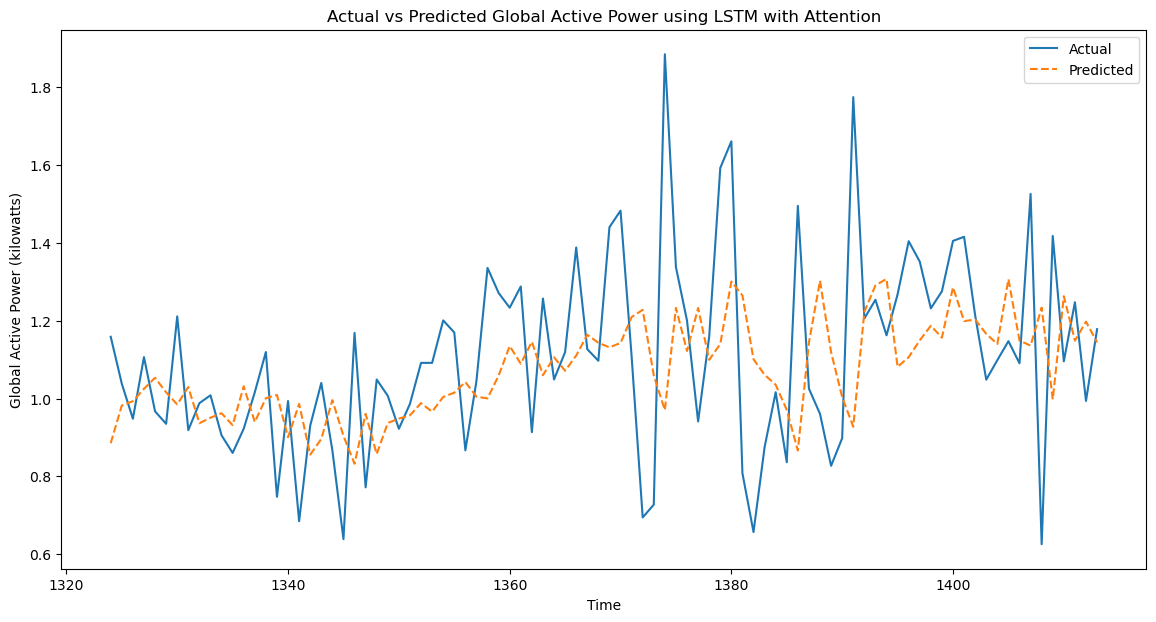

In [4]:
# Question 6: Implement Long Short-Term Memory (LSTM)
print("ANSWER #6")
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM
plot_training_history(history, "LSTM", "Resampled Data")

lstm_predictions = lstm_model.predict(X_test).flatten()

# Evaluate LSTM model
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
mse_lstm = mean_squared_error(y_test, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, lstm_predictions)

print("LSTM Results")
print(f'Mean Absolute Error (MAE): {mae_lstm:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.4f}')
print(f'R-squared (R²) value: {r2_lstm:.4f}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), lstm_predictions, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power using LSTM')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe
performance_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'RNN', 'LSTM'],
    'MAE': [mae, mae_rnn, mae_lstm],
    'MSE': [mse, mse_rnn, mse_lstm],
    'RMSE': [rmse, rmse_rnn, rmse_lstm],
    'R²': [r2, r2_rnn, r2_lstm]
})

# Apply the highlight_max and highlight_min styles for performance_comparison
styled_df = (performance_comparison.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
styled_df

# Question 7: Implement LSTM with Attention
print("ANSWER #7")
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

lstm_attention_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    AttentionLayer(),
    Dense(1)
])
lstm_attention_model.compile(optimizer='adam', loss='mse')
history = lstm_attention_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with Attention
plot_training_history(history, "LSTM with Attention", "Resampled Data")

lstm_attention_predictions = lstm_attention_model.predict(X_test).flatten()

# Evaluate LSTM with Attention model
mae_lstm_att = mean_absolute_error(y_test, lstm_attention_predictions)
mse_lstm_att = mean_squared_error(y_test, lstm_attention_predictions)
rmse_lstm_att = np.sqrt(mse_lstm_att)
r2_lstm_att = r2_score(y_test, lstm_attention_predictions)

print("LSTM with Attention Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_att:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_att:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_att:.4f}')
print(f'R-squared (R²) value: {r2_lstm_att:.4f}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), lstm_attention_predictions, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power using LSTM with Attention')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe
performance_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'RNN', 'LSTM', 'LSTM with Attention'],
    'MAE': [mae, mae_rnn, mae_lstm, mae_lstm_att],
    'MSE': [mse, mse_rnn, mse_lstm, mse_lstm_att],
    'RMSE': [rmse, rmse_rnn, rmse_lstm, rmse_lstm_att],
    'R²': [r2, r2_rnn, r2_lstm, r2_lstm_att]
})

# Apply the highlight_max and highlight_min styles for performance_comparison
styled_df = (performance_comparison.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
styled_df

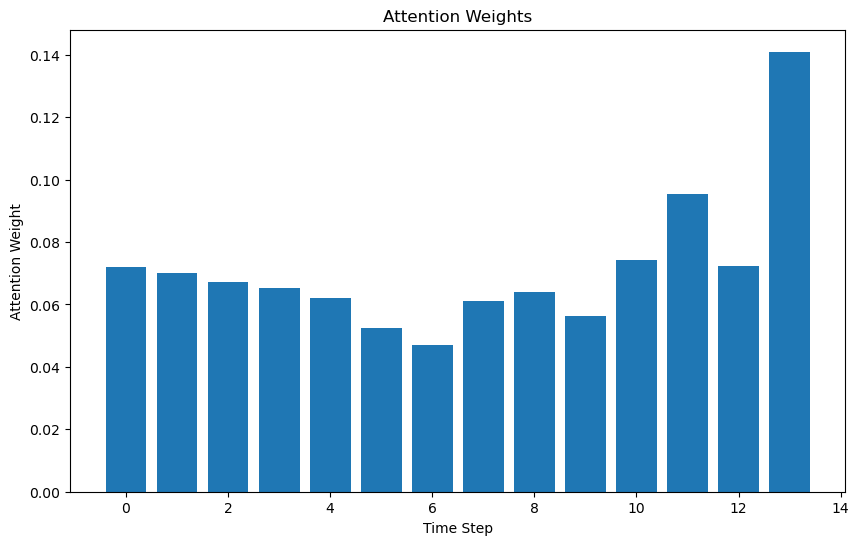

### 6. Long Short-Term Memory (LSTM) Model

We implemented an LSTM model to predict power consumption. The data was preprocessed for LSTM input, the model was designed and trained for several epochs, and predictions were made.

#### Evaluation Metrics

- **Mean Absolute Error (MAE)**: 0.1895
- **Mean Squared Error (MSE)**: 0.0619
- **Root Mean Squared Error (RMSE)**: 0.2487
- **R-squared (R²) value**: -0.0261

#### Comparison with Previous Models

- **MAE**: Slightly worse than RNN (0.1806) but better than Linear Regression (0.1990)
- **MSE**: Slightly worse than RNN (0.0590) but better than Linear Regression (0.0716)
- **RMSE**: Slightly worse than RNN (0.2430) but better than Linear Regression (0.2677)
- **R²**: Worse than RNN (0.0210) but better than Linear Regression (-0.1882)

The LSTM model does not outperform the RNN model but performs better than the linear regression model in most metrics.

### Conclusion

The LSTM model provides better predictions than the linear regression model but does not outperform the RNN model. Further tuning and model adjustments may be needed to fully leverage the potential of LSTM networks.

### 7. LSTM with Attention Layer

We implemented an LSTM model with an Attention layer to predict power consumption. The data was preprocessed for LSTM with Attention input, the model was designed and trained for several epochs, and predictions were made.

#### Evaluation Metrics

- **Mean Absolute Error (MAE)**: 0.1922
- **Mean Squared Error (MSE)**: 0.0663
- **Root Mean Squared Error (RMSE)**: 0.2575
- **R-squared (R²) value**: -0.1000

#### Comparison with Previous Models

- **MAE**: Slightly worse than RNN (0.1806) and LSTM (0.1895), but better than Linear Regression (0.1990)
- **MSE**: Worse than RNN (0.0590) and LSTM (0.0619), but better than Linear Regression (0.0716)
- **RMSE**: Worse than RNN (0.2430) and LSTM (0.2487), but better than Linear Regression (0.2677)
- **R²**: Worse than RNN (0.0210), LSTM (-0.0261), and Linear Regression (-0.1882)

The LSTM with Attention model does not outperform the other models.

### Conclusion

The LSTM with Attention model did not perform as well as the RNN and LSTM models. Its performance is slightly better than the linear regression model but does not leverage the potential benefits of the Attention mechanism. Further refinement is needed.


ANSWER #8
Epoch [10/100], Loss: 0.0348
Epoch [20/100], Loss: 0.0272
Epoch [30/100], Loss: 0.0234
Epoch [40/100], Loss: 0.0227
Epoch [50/100], Loss: 0.0223
Epoch [60/100], Loss: 0.0219
Epoch [70/100], Loss: 0.0216
Epoch [80/100], Loss: 0.0212
Epoch [90/100], Loss: 0.0210
Epoch [100/100], Loss: 0.0207


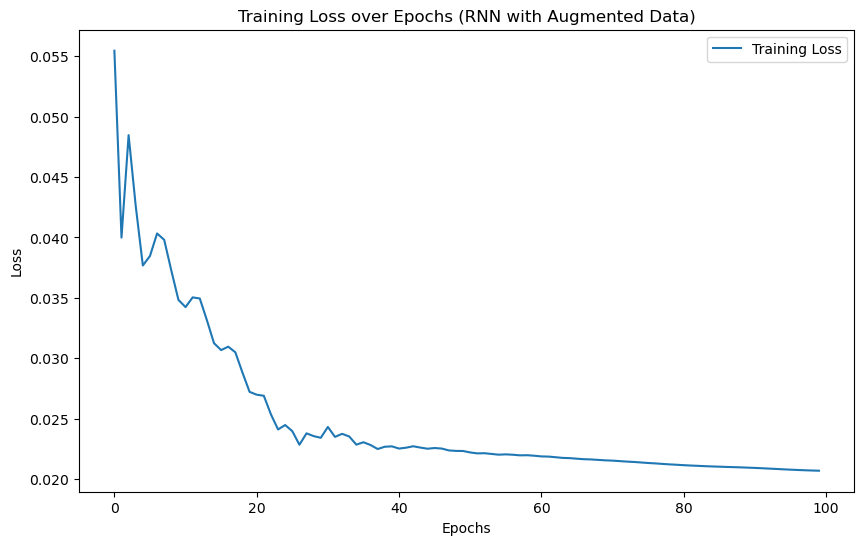

Augmented RNN Results
Mean Absolute Error (MAE): 0.1712
Mean Squared Error (MSE): 0.0546
Root Mean Squared Error (RMSE): 0.2337
R-squared (R²) value: 0.3635


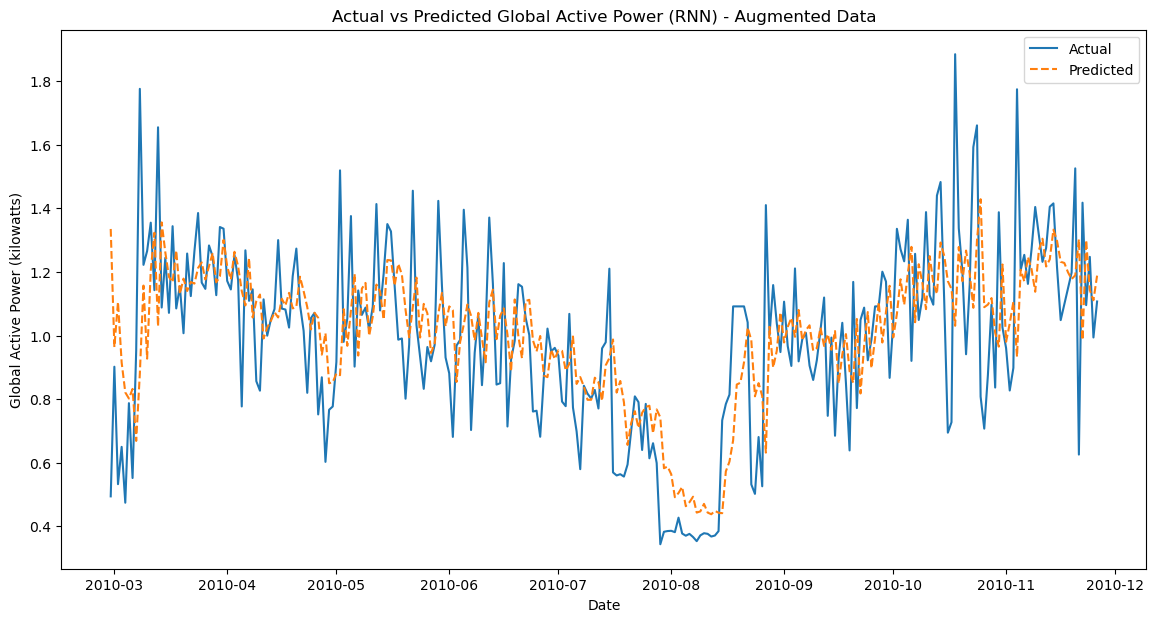

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1181
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197
Epoc

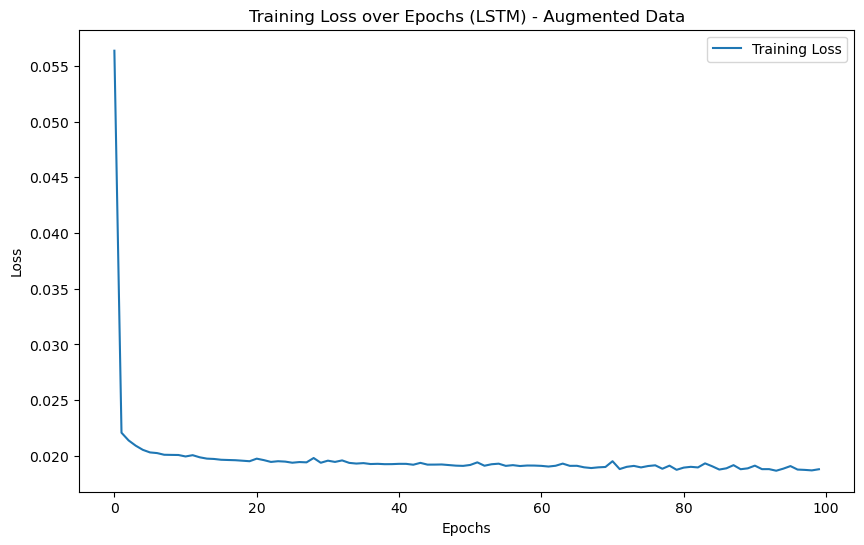

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Augmented LSTM Results
Mean Absolute Error (MAE): 0.1668
Mean Squared Error (MSE): 0.0503
Root Mean Squared Error (RMSE): 0.2244
R-squared (R²) value: 0.4131


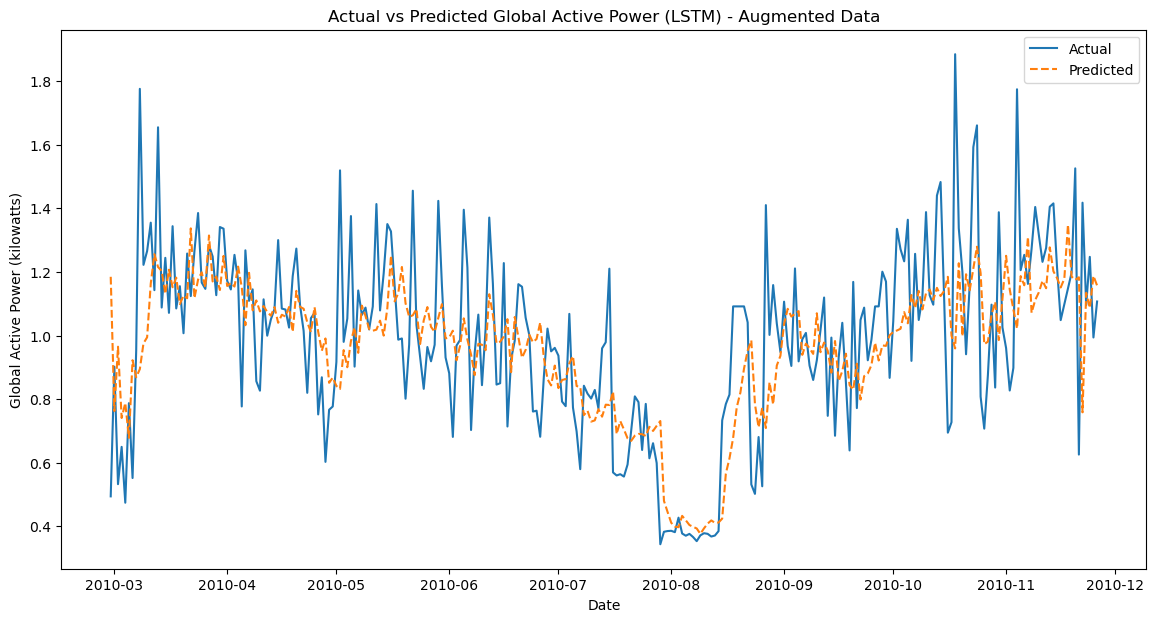

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1302
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219
Epoc

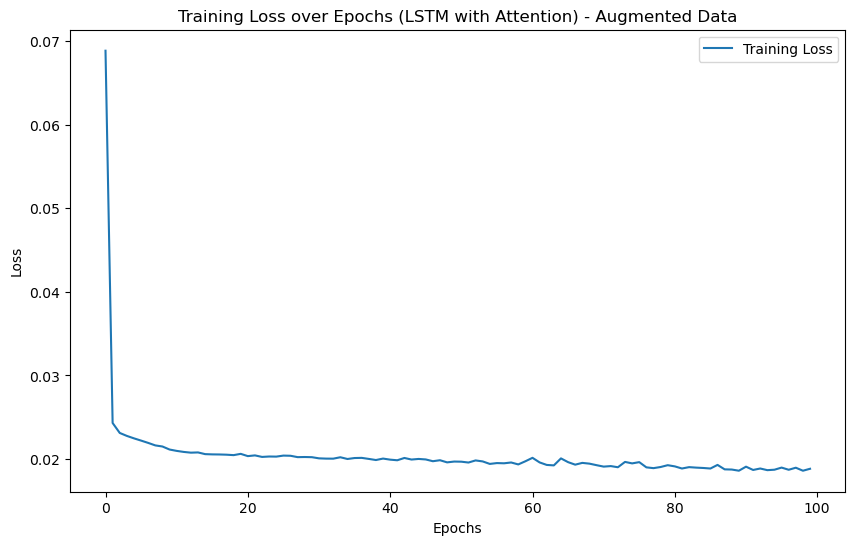

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Augmented LSTM with Attention Results
Mean Absolute Error (MAE): 0.1667
Mean Squared Error (MSE): 0.0510
Root Mean Squared Error (RMSE): 0.2259
R-squared (R²) value: 0.4051


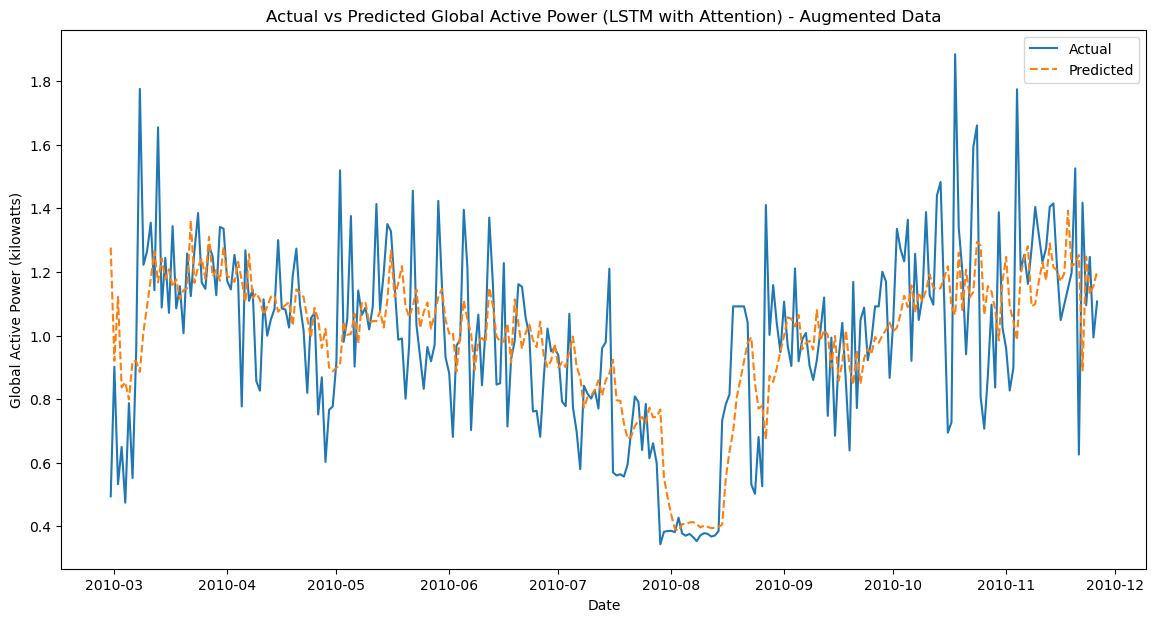

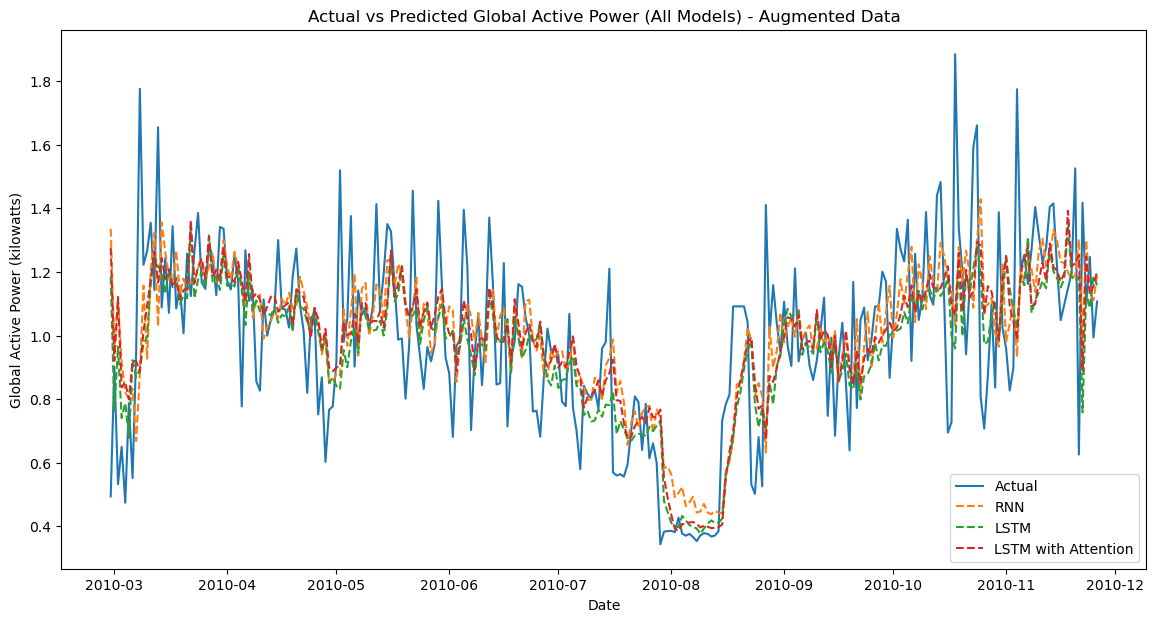

In [5]:
# Question 8: Data Augmentation Experiment
print("ANSWER #8")
# Augment the data by modifying up to 10% of the dataset
augmented_df = daily_data.copy()
num_modifications = int(0.1 * len(daily_data))
random_indices = np.random.choice(daily_data.index, size=num_modifications, replace=False)
augmented_df.loc[random_indices, 'Global_active_power'] *= np.random.uniform(0.9, 1.1, size=num_modifications)

# Split augmented data
train_aug, test_aug = train_test_split(augmented_df, test_size=0.2, shuffle=False)
train_aug['lag1'] = train_aug['Global_active_power'].shift(1)
train_aug = train_aug.dropna()

# Define features and target variable
features = [f'lag_{i}' for i in range(1, 15)]
target = 'Global_active_power'

# Prepare features (consider lag variables, time-based features)
for i in range(1, 15):
    train_aug[f'lag_{i}'] = train_aug['Global_active_power'].shift(i)
train_aug = train_aug.dropna()

X_train_aug = train_aug[features]
y_train_aug = train_aug[target]

# Apply the same lag feature creation to the test set
for i in range(1, 15):
    test_aug[f'lag_{i}'] = test_aug['Global_active_power'].shift(i)
test_aug = test_aug.dropna()

X_test_aug = test_aug[features]
y_test_aug = test_aug[target]

# RNN with augmented data
scaler_aug = MinMaxScaler()
scaled_data_aug = scaler_aug.fit_transform(augmented_df[['Global_active_power']])

X_train_rnn_aug, y_train_rnn_aug = create_sequences(scaled_data_aug[:-len(test_aug)], SEQ_LENGTH)
X_test_rnn_aug, y_test_rnn_aug = create_sequences(scaled_data_aug[-len(test_aug)-SEQ_LENGTH:], SEQ_LENGTH)

X_train_rnn_aug = torch.tensor(X_train_rnn_aug, dtype=torch.float32)
y_train_rnn_aug = torch.tensor(y_train_rnn_aug, dtype=torch.float32)
X_test_rnn_aug = torch.tensor(X_test_rnn_aug, dtype=torch.float32)
y_test_rnn_aug = torch.tensor(y_test_rnn_aug, dtype=torch.float32)

# Initialize the RNN model for augmented data, loss function, and optimizer
model_rnn_aug = RNN(input_size, hidden_size, num_layers, output_size)
criterion_aug = nn.MSELoss()
optimizer_aug = torch.optim.Adam(model_rnn_aug.parameters(), lr=learning_rate)

# Train the RNN model with augmented data
rnn_history_aug = []
for epoch in range(num_epochs):
    model_rnn_aug.train()
    outputs = model_rnn_aug(X_train_rnn_aug)
    optimizer_aug.zero_grad()
    loss = criterion_aug(outputs, y_train_rnn_aug)
    loss.backward()
    optimizer_aug.step()
    rnn_history_aug.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss for RNN with augmented data
plt.figure(figsize=(10, 6))
plt.plot(rnn_history_aug, label='Training Loss')
plt.title('Training Loss over Epochs (RNN with Augmented Data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the RNN model with augmented data
model_rnn_aug.eval()
with torch.no_grad():
    rnn_predictions_aug = model_rnn_aug(X_test_rnn_aug).numpy().flatten()

# Inverse transform the predictions
rnn_predictions_aug = scaler_aug.inverse_transform(rnn_predictions_aug.reshape(-1, 1)).flatten()

mae_rnn_aug = mean_absolute_error(y_test_aug, rnn_predictions_aug)
mse_rnn_aug = mean_squared_error(y_test_aug, rnn_predictions_aug)
rmse_rnn_aug = np.sqrt(mse_rnn_aug)
r2_rnn_aug = r2_score(y_test_aug, rnn_predictions_aug)

print("Augmented RNN Results")
print(f'Mean Absolute Error (MAE): {mae_rnn_aug:.4f}')
print(f'Mean Squared Error (MSE): {mse_rnn_aug:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rnn_aug:.4f}')
print(f'R-squared (R²) value: {r2_rnn_aug:.4f}')

# Plot the results for RNN
plt.figure(figsize=(14, 7))
plt.plot(test_aug.index, y_test_aug, label='Actual')
plt.plot(test_aug.index, rnn_predictions_aug, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (RNN) - Augmented Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# LSTM with augmented data
history = lstm_model.fit(X_train_rnn_aug, y_train_rnn_aug, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with augmented data
plot_training_history(history, "LSTM", "Augmented Data")

lstm_predictions_aug = lstm_model.predict(X_test_rnn_aug).flatten()

# Inverse transform the predictions
lstm_predictions_aug = scaler_aug.inverse_transform(lstm_predictions_aug.reshape(-1, 1)).flatten()

mae_lstm_aug = mean_absolute_error(y_test_aug, lstm_predictions_aug)
mse_lstm_aug = mean_squared_error(y_test_aug, lstm_predictions_aug)
rmse_lstm_aug = np.sqrt(mse_lstm_aug)
r2_lstm_aug = r2_score(y_test_aug, lstm_predictions_aug)

print("Augmented LSTM Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_aug:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_aug:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_aug:.4f}')
print(f'R-squared (R²) value: {r2_lstm_aug:.4f}')


# Plot the results for LSTM
plt.figure(figsize=(14, 7))
plt.plot(test_aug.index, y_test_aug, label='Actual')
plt.plot(test_aug.index, lstm_predictions_aug, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (LSTM) - Augmented Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# LSTM with Attention and augmented data
history = lstm_attention_model.fit(X_train_rnn_aug, y_train_rnn_aug, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with Attention and augmented data
plot_training_history(history, "LSTM with Attention", "Augmented Data")

lstm_attention_predictions_aug = lstm_attention_model.predict(X_test_rnn_aug).flatten()

# Inverse transform the predictions
lstm_attention_predictions_aug = scaler_aug.inverse_transform(lstm_attention_predictions_aug.reshape(-1, 1)).flatten()

mae_lstm_att_aug = mean_absolute_error(y_test_aug, lstm_attention_predictions_aug)
mse_lstm_att_aug = mean_squared_error(y_test_aug, lstm_attention_predictions_aug)
rmse_lstm_att_aug = np.sqrt(mse_lstm_att_aug)
r2_lstm_att_aug = r2_score(y_test_aug, lstm_attention_predictions_aug)

print("Augmented LSTM with Attention Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_att_aug:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_att_aug:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_att_aug:.4f}')
print(f'R-squared (R²) value: {r2_lstm_att_aug:.4f}')


# Plot the results for LSTM with Attention
plt.figure(figsize=(14, 7))
plt.plot(test_aug.index, y_test_aug, label='Actual')
plt.plot(test_aug.index, lstm_attention_predictions_aug, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (LSTM with Attention) - Augmented Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe for augmented data
performance_comparison_aug = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'LSTM with Attention'],
    'MAE': [mae_rnn_aug, mae_lstm_aug, mae_lstm_att_aug],
    'MSE': [mse_rnn_aug, mse_lstm_aug, mse_lstm_att_aug],
    'RMSE': [rmse_rnn_aug, rmse_lstm_aug, rmse_lstm_att_aug],
    'R²': [r2_rnn_aug, r2_lstm_aug, r2_lstm_att_aug]
})

# Apply the highlight_max and highlight_min styles for performance_comparison_aug
styled_df_aug = (performance_comparison_aug.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
display(styled_df_aug)

# Plot combined results
plt.figure(figsize=(14, 7))
plt.plot(test_aug.index, y_test_aug, label='Actual')
plt.plot(test_aug.index, rnn_predictions_aug, label='RNN', linestyle='--')
plt.plot(test_aug.index, lstm_predictions_aug, label='LSTM', linestyle='--')
plt.plot(test_aug.index, lstm_attention_predictions_aug, label='LSTM with Attention', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (All Models) - Augmented Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

### 8. Data Augmentation Experiment

In this task, we augmented the data by modifying up to 10% of the dataset. The purpose of this experiment was to determine if introducing slight variations in the data could improve model performance.

#### Methodology

1. **Data Augmentation**: We randomly selected 10% of the data points and slightly modified their values by multiplying them with random factors between 0.9 and 1.1.
2. **Model Training**: The augmented data was used to train three models: RNN, LSTM, and LSTM with Attention.
3. **Evaluation**: We evaluated the performance of each model on the augmented data using MAE, MSE, RMSE, and R² metrics.

#### Results

- **RNN with Augmented Data**:
  - **Mean Absolute Error (MAE)**: 0.1712
  - **Mean Squared Error (MSE)**: 0.0546
  - **Root Mean Squared Error (RMSE)**: 0.2337
  - **R-squared (R²) value**: 0.3635

- **LSTM with Augmented Data**:
  - **Mean Absolute Error (MAE)**: 0.1668
  - **Mean Squared Error (MSE)**: 0.0503
  - **Root Mean Squared Error (RMSE)**: 0.2244
  - **R-squared (R²) value**: 0.4131

- **LSTM with Attention and Augmented Data**:
  - **Mean Absolute Error (MAE)**: 0.1667
  - **Mean Squared Error (MSE)**: 0.0510
  - **Root Mean Squared Error (RMSE)**: 0.2259
  - **R-squared (R²) value**: 0.4051

#### Conclusion

Data augmentation improved the performance of all models. The LSTM model with augmented data had the best performance, followed closely by the LSTM with Attention model. The RNN model also showed significant improvement compared to its performance without data augmentation. These results indicate that data augmentation can be an effective technique for enhancing model accuracy.


ANSWER #9
Epoch [10/100], Loss: 0.0667
Epoch [20/100], Loss: 0.0457
Epoch [30/100], Loss: 0.0399
Epoch [40/100], Loss: 0.0358
Epoch [50/100], Loss: 0.0304
Epoch [60/100], Loss: 0.0250
Epoch [70/100], Loss: 0.0248
Epoch [80/100], Loss: 0.0247
Epoch [90/100], Loss: 0.0245
Epoch [100/100], Loss: 0.0244


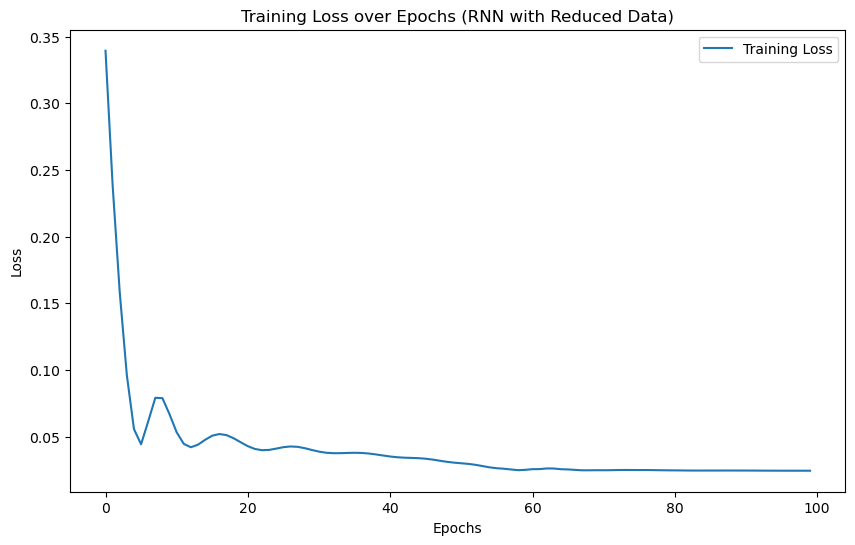

Reduced RNN Results
Mean Absolute Error (MAE): 0.1809
Mean Squared Error (MSE): 0.0562
Root Mean Squared Error (RMSE): 0.2370
R-squared (R²) value: 0.3531


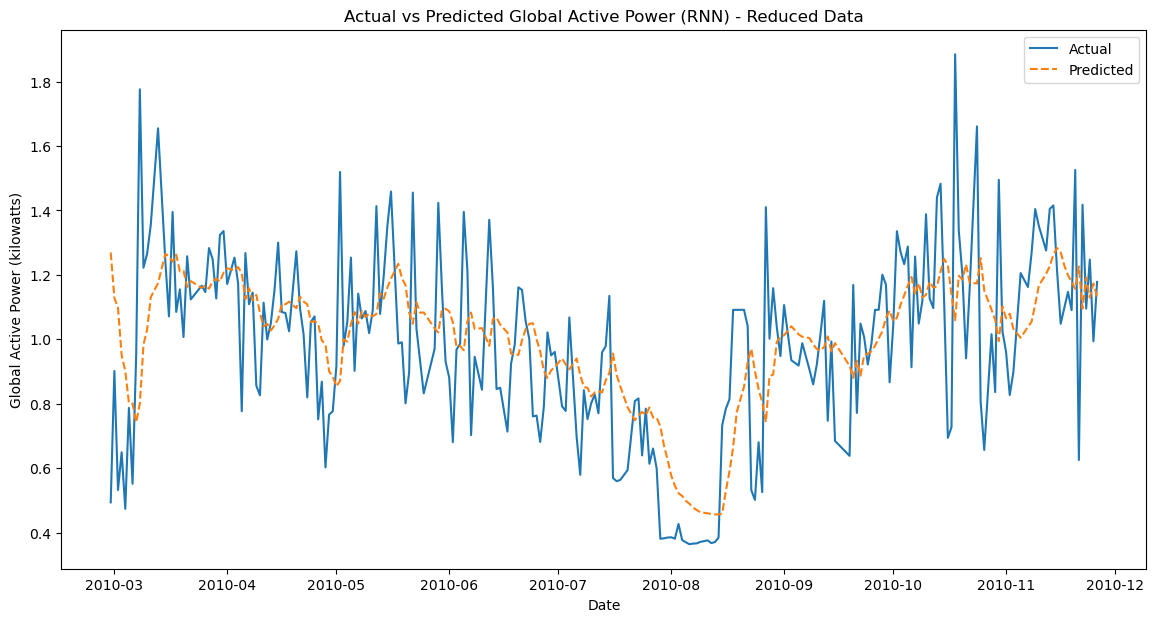

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222
Epoc

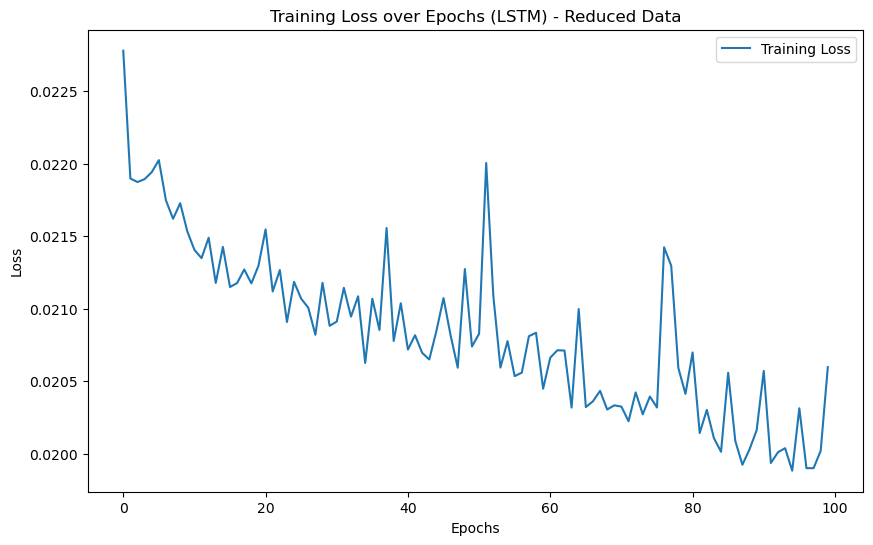

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Reduced LSTM Results
Mean Absolute Error (MAE): 0.1904
Mean Squared Error (MSE): 0.0603
Root Mean Squared Error (RMSE): 0.2455
R-squared (R²) value: 0.3056


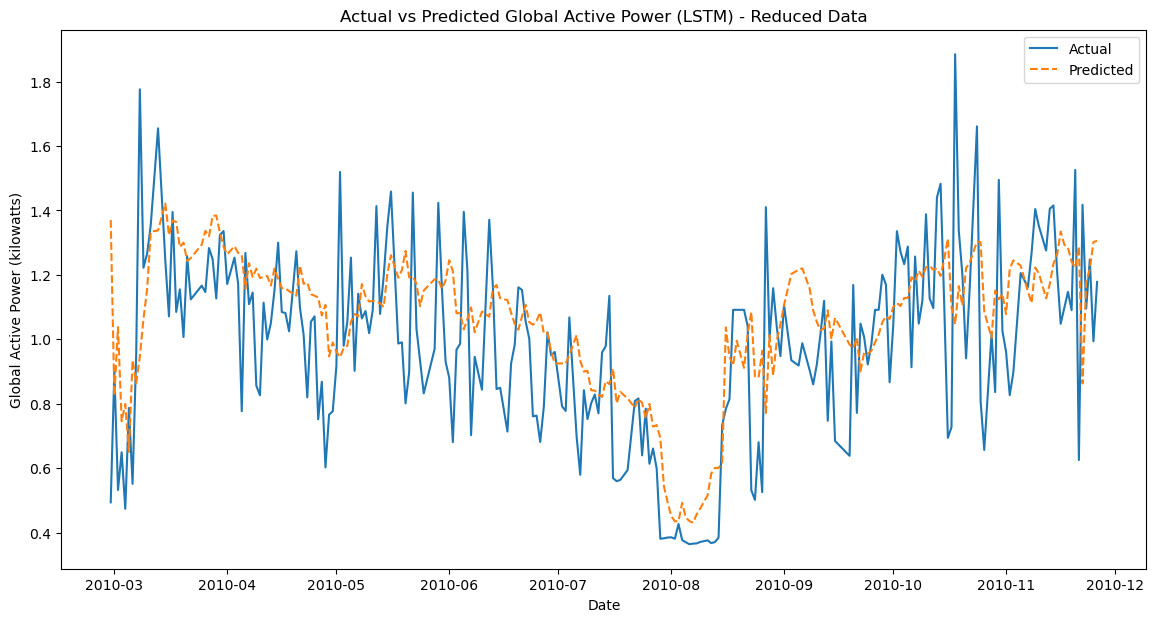

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoc

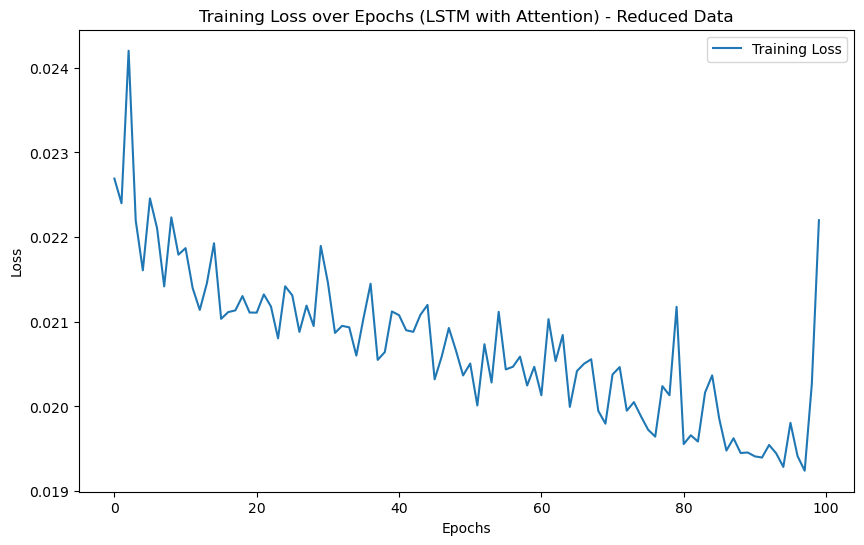

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Reduced LSTM with Attention Results
Mean Absolute Error (MAE): 0.1914
Mean Squared Error (MSE): 0.0612
Root Mean Squared Error (RMSE): 0.2474
R-squared (R²) value: 0.2949


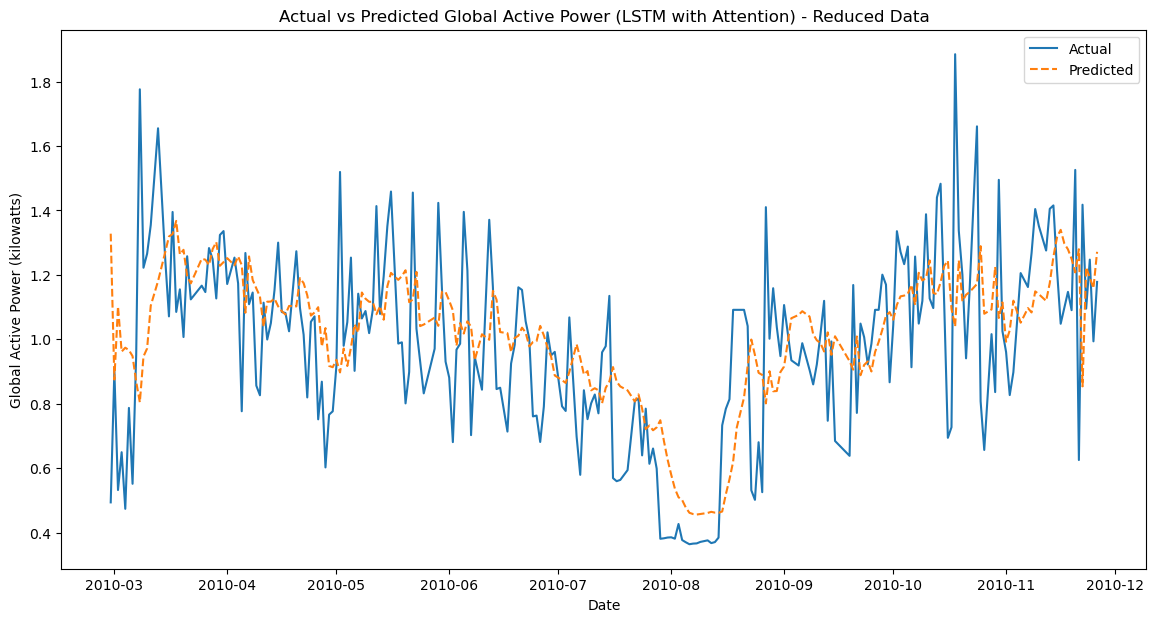

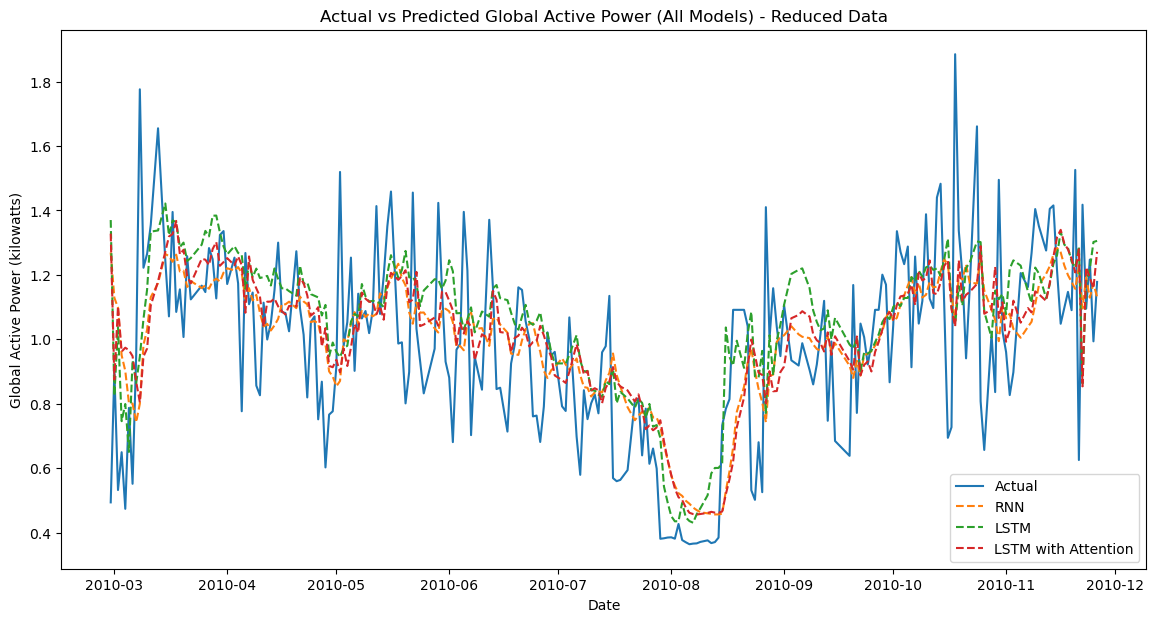

In [6]:
# Question 9: Data Reduction Experiment
print("ANSWER #9")
# Reduce the data by removing up to 10% of the dataset
reduced_df = daily_data.drop(daily_data.sample(frac=0.1, random_state=1).index)

# Split reduced data
train_red, test_red = train_test_split(reduced_df, test_size=0.2, shuffle=False)
train_red['lag1'] = train_red['Global_active_power'].shift(1)
train_red = train_red.dropna()

# Define features and target variable
features = [f'lag_{i}' for i in range(1, 15)]
target = 'Global_active_power'

# Prepare features (consider lag variables, time-based features)
for i in range(1, 15):
    train_red[f'lag_{i}'] = train_red['Global_active_power'].shift(i)
train_red = train_red.dropna()

X_train_red = train_red[features]
y_train_red = train_red[target]

# Apply the same lag feature creation to the test set
for i in range(1, 15):
    test_red[f'lag_{i}'] = test_red['Global_active_power'].shift(i)
test_red = test_red.dropna()

X_test_red = test_red[features]
y_test_red = test_red[target]

# RNN with reduced data
scaler_red = MinMaxScaler()
scaled_data_red = scaler_red.fit_transform(reduced_df[['Global_active_power']])

X_train_rnn_red, y_train_rnn_red = create_sequences(scaled_data_red[:-len(test_red)], SEQ_LENGTH)
X_test_rnn_red, y_test_rnn_red = create_sequences(scaled_data_red[-len(test_red)-SEQ_LENGTH:], SEQ_LENGTH)

X_train_rnn_red = torch.tensor(X_train_rnn_red, dtype=torch.float32)
y_train_rnn_red = torch.tensor(y_train_rnn_red, dtype=torch.float32)
X_test_rnn_red = torch.tensor(X_test_rnn_red, dtype=torch.float32)
y_test_rnn_red = torch.tensor(y_test_rnn_red, dtype=torch.float32)

# Initialize the RNN model for reduced data, loss function, and optimizer
model_rnn_red = RNN(input_size, hidden_size, num_layers, output_size)
criterion_red = nn.MSELoss()
optimizer_red = torch.optim.Adam(model_rnn_red.parameters(), lr=learning_rate)

# Train the RNN model with reduced data
rnn_history_red = []
for epoch in range(num_epochs):
    model_rnn_red.train()
    outputs = model_rnn_red(X_train_rnn_red)
    optimizer_red.zero_grad()
    loss = criterion_red(outputs, y_train_rnn_red)
    loss.backward()
    optimizer_red.step()
    rnn_history_red.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss for RNN with reduced data
plt.figure(figsize=(10, 6))
plt.plot(rnn_history_red, label='Training Loss')
plt.title('Training Loss over Epochs (RNN with Reduced Data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the RNN model with reduced data
model_rnn_red.eval()
with torch.no_grad():
    rnn_predictions_red = model_rnn_red(X_test_rnn_red).numpy().flatten()

# Inverse transform the predictions
rnn_predictions_red = scaler_red.inverse_transform(rnn_predictions_red.reshape(-1, 1)).flatten()

mae_rnn_red = mean_absolute_error(y_test_red, rnn_predictions_red)
mse_rnn_red = mean_squared_error(y_test_red, rnn_predictions_red)
rmse_rnn_red = np.sqrt(mse_rnn_red)
r2_rnn_red = r2_score(y_test_red, rnn_predictions_red)


print("Reduced RNN Results")
print(f'Mean Absolute Error (MAE): {mae_rnn_red:.4f}')
print(f'Mean Squared Error (MSE): {mse_rnn_red:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rnn_red:.4f}')
print(f'R-squared (R²) value: {r2_rnn_red:.4f}')


# Plot the results for RNN
plt.figure(figsize=(14, 7))
plt.plot(test_red.index, y_test_red, label='Actual')
plt.plot(test_red.index, rnn_predictions_red, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (RNN) - Reduced Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# LSTM with reduced data
history = lstm_model.fit(X_train_rnn_red, y_train_rnn_red, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with reduced data
plot_training_history(history, "LSTM", "Reduced Data")

lstm_predictions_red = lstm_model.predict(X_test_rnn_red).flatten()

# Inverse transform the predictions
lstm_predictions_red = scaler_red.inverse_transform(lstm_predictions_red.reshape(-1, 1)).flatten()

mae_lstm_red = mean_absolute_error(y_test_red, lstm_predictions_red)
mse_lstm_red = mean_squared_error(y_test_red, lstm_predictions_red)
rmse_lstm_red = np.sqrt(mse_lstm_red)
r2_lstm_red = r2_score(y_test_red, lstm_predictions_red)

print("Reduced LSTM Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_red:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_red:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_red:.4f}')
print(f'R-squared (R²) value: {r2_lstm_red:.4f}')


# Plot the results for LSTM
plt.figure(figsize=(14, 7))
plt.plot(test_red.index, y_test_red, label='Actual')
plt.plot(test_red.index, lstm_predictions_red, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (LSTM) - Reduced Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# LSTM with Attention and reduced data
history = lstm_attention_model.fit(X_train_rnn_red, y_train_rnn_red, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with Attention and reduced data
plot_training_history(history, "LSTM with Attention", "Reduced Data")

lstm_attention_predictions_red = lstm_attention_model.predict(X_test_rnn_red).flatten()

# Inverse transform the predictions
lstm_attention_predictions_red = scaler_red.inverse_transform(lstm_attention_predictions_red.reshape(-1, 1)).flatten()

mae_lstm_att_red = mean_absolute_error(y_test_red, lstm_attention_predictions_red)
mse_lstm_att_red = mean_squared_error(y_test_red, lstm_attention_predictions_red)
rmse_lstm_att_red = np.sqrt(mse_lstm_att_red)
r2_lstm_att_red = r2_score(y_test_red, lstm_attention_predictions_red)

print("Reduced LSTM with Attention Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_att_red:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_att_red:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_att_red:.4f}')
print(f'R-squared (R²) value: {r2_lstm_att_red:.4f}')


# Plot the results for LSTM with Attention
plt.figure(figsize=(14, 7))
plt.plot(test_red.index, y_test_red, label='Actual')
plt.plot(test_red.index, lstm_attention_predictions_red, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (LSTM with Attention) - Reduced Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe for reduced data
performance_comparison_red = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'LSTM with Attention'],
    'MAE': [mae_rnn_red, mae_lstm_red, mae_lstm_att_red],
    'MSE': [mse_rnn_red, mse_lstm_red, mse_lstm_att_red],
    'RMSE': [rmse_rnn_red, rmse_lstm_red, rmse_lstm_att_red],
    'R²': [r2_rnn_red, r2_lstm_red, r2_lstm_att_red]
})

# Apply the highlight_max and highlight_min styles for performance_comparison_red
styled_df_red = (performance_comparison_red.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
display(styled_df_red)

# Plot combined results
plt.figure(figsize=(14, 7))
plt.plot(test_red.index, y_test_red, label='Actual')
plt.plot(test_red.index, rnn_predictions_red, label='RNN', linestyle='--')
plt.plot(test_red.index, lstm_predictions_red, label='LSTM', linestyle='--')
plt.plot(test_red.index, lstm_attention_predictions_red, label='LSTM with Attention', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (All Models) - Reduced Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

### 9. Data Reduction Experiment

In this task, we reduced the data by removing up to 10% of the dataset. The objective was to determine the impact of data reduction on model performance.

#### Methodology

1. **Data Reduction**: We randomly removed 10% of the data points from the dataset.
2. **Model Training**: The reduced data was used to train three models: RNN, LSTM, and LSTM with Attention.
3. **Evaluation**: We evaluated the performance of each model on the reduced data using MAE, MSE, RMSE, and R² metrics.

#### Results

- **RNN with Reduced Data**:
  - **Mean Absolute Error (MAE)**: 0.1809
  - **Mean Squared Error (MSE)**: 0.0562
  - **Root Mean Squared Error (RMSE)**: 0.2370
  - **R-squared (R²) value**: 0.3531

- **LSTM with Reduced Data**:
  - **Mean Absolute Error (MAE)**: 0.1904
  - **Mean Squared Error (MSE)**: 0.0603
  - **Root Mean Squared Error (RMSE)**: 0.2455
  - **R-squared (R²) value**: 0.3056

- **LSTM with Attention and Reduced Data**:
  - **Mean Absolute Error (MAE)**: 0.1914
  - **Mean Squared Error (MSE)**: 0.0612
  - **Root Mean Squared Error (RMSE)**: 0.2474
  - **R-squared (R²) value**: 0.2949

#### Conclusion

Data reduction resulted in a slight decrease in model performance across all models. The RNN model performed the best on the reduced data, similar to its performance with the full dataset. The LSTM and LSTM with Attention models showed a decrease in performance, indicating their sensitivity to data reduction. These results suggest that while RNNs are more robust to data reduction, more sophisticated models like LSTMs may require a larger dataset to maintain their performance.


ANSWER #10
Epoch [10/100], Loss: 0.0300
Epoch [20/100], Loss: 0.0255
Epoch [30/100], Loss: 0.0224
Epoch [40/100], Loss: 0.0192
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0136


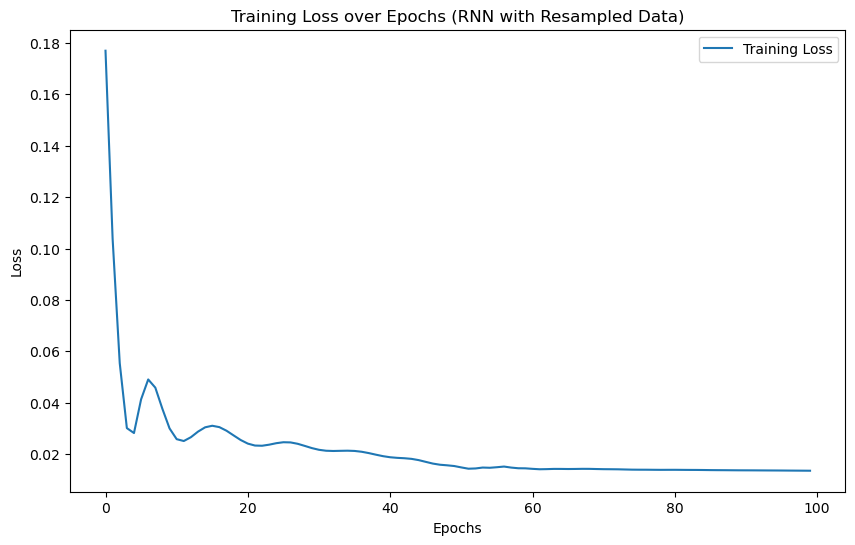

Resampled RNN Results
Mean Absolute Error (MAE): 0.0665
Mean Squared Error (MSE): 0.0079
Root Mean Squared Error (RMSE): 0.0888
R-squared (R²) value: 0.3913


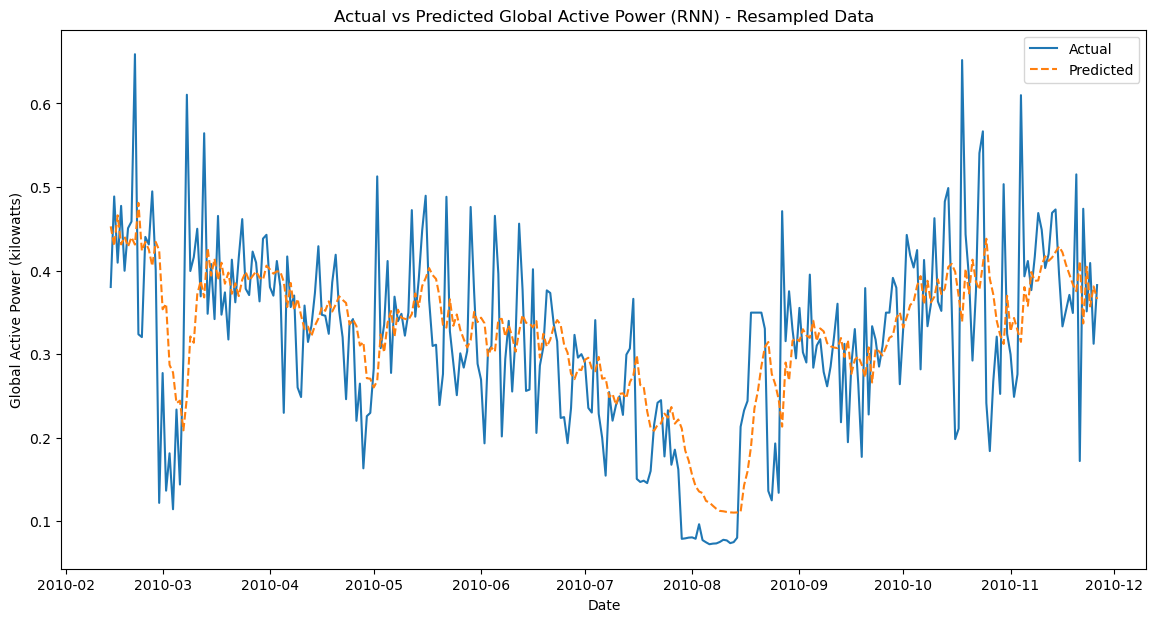

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111
Epoc

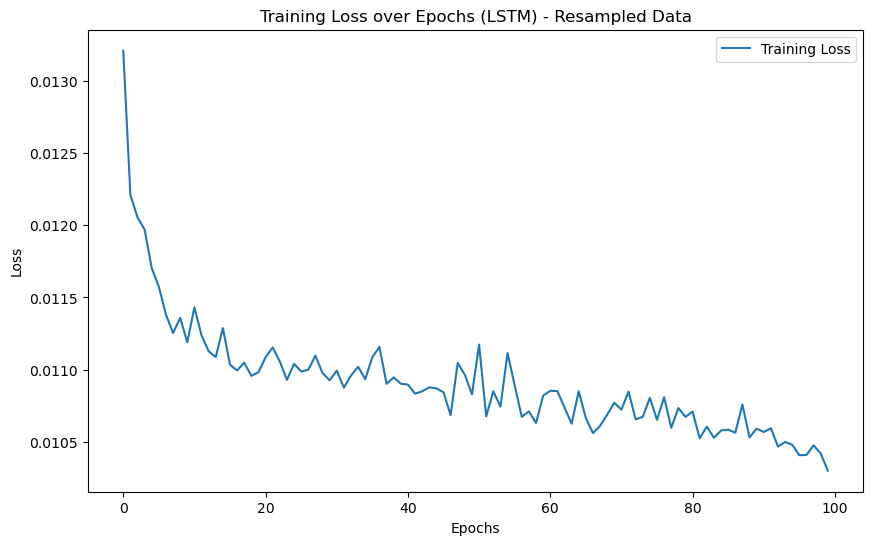

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Resampled LSTM Results
Mean Absolute Error (MAE): 0.0658
Mean Squared Error (MSE): 0.0076
Root Mean Squared Error (RMSE): 0.0874
R-squared (R²) value: 0.4109


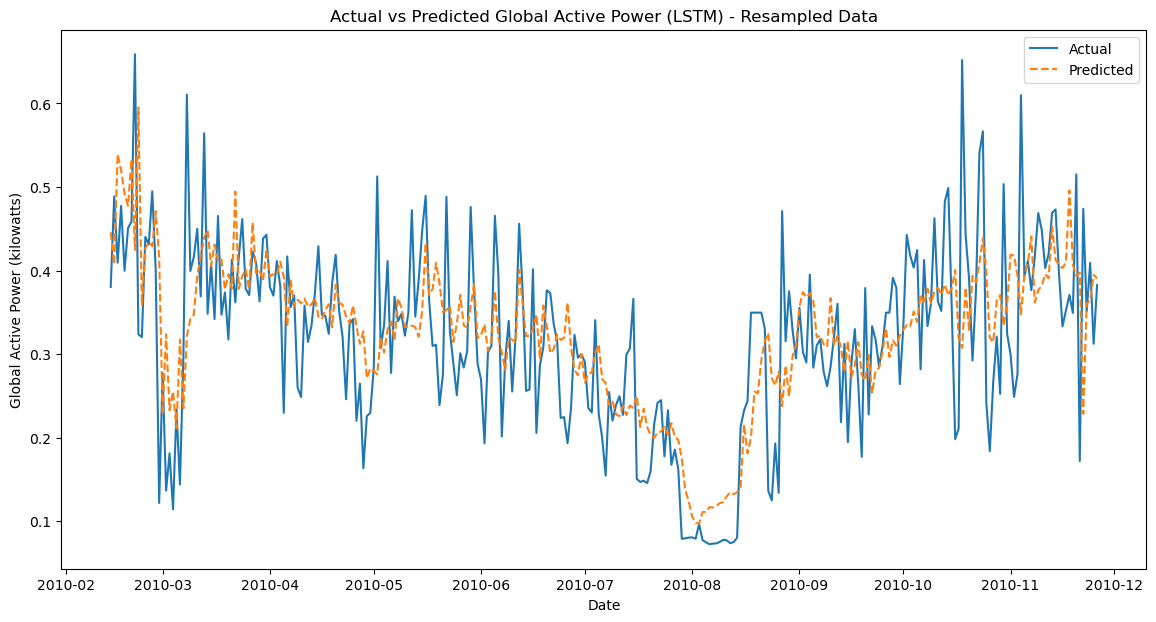

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoc

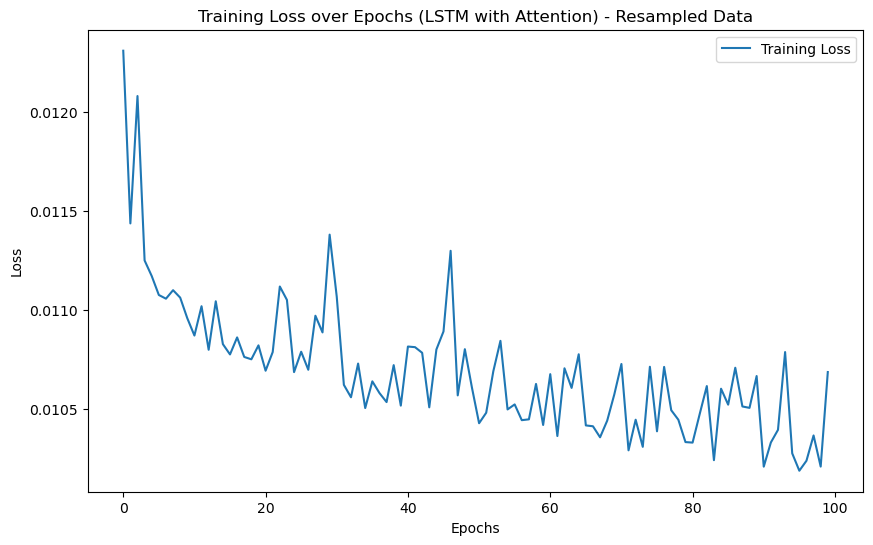

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Resampled LSTM with Attention Results
Mean Absolute Error (MAE): 0.0647
Mean Squared Error (MSE): 0.0076
Root Mean Squared Error (RMSE): 0.0873
R-squared (R²) value: 0.4118


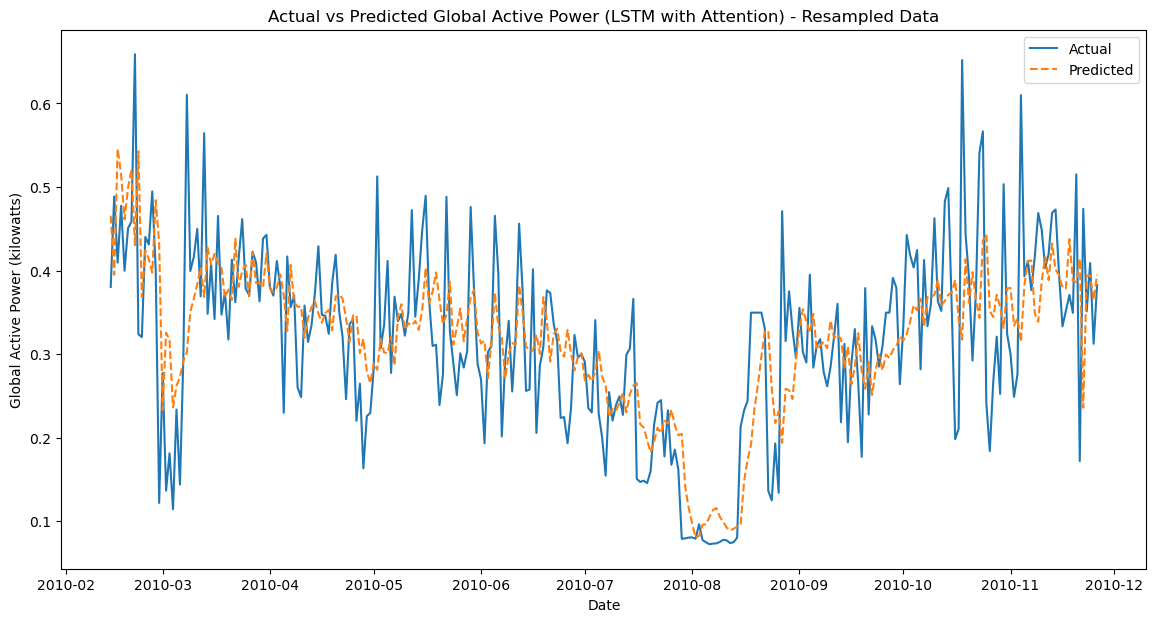

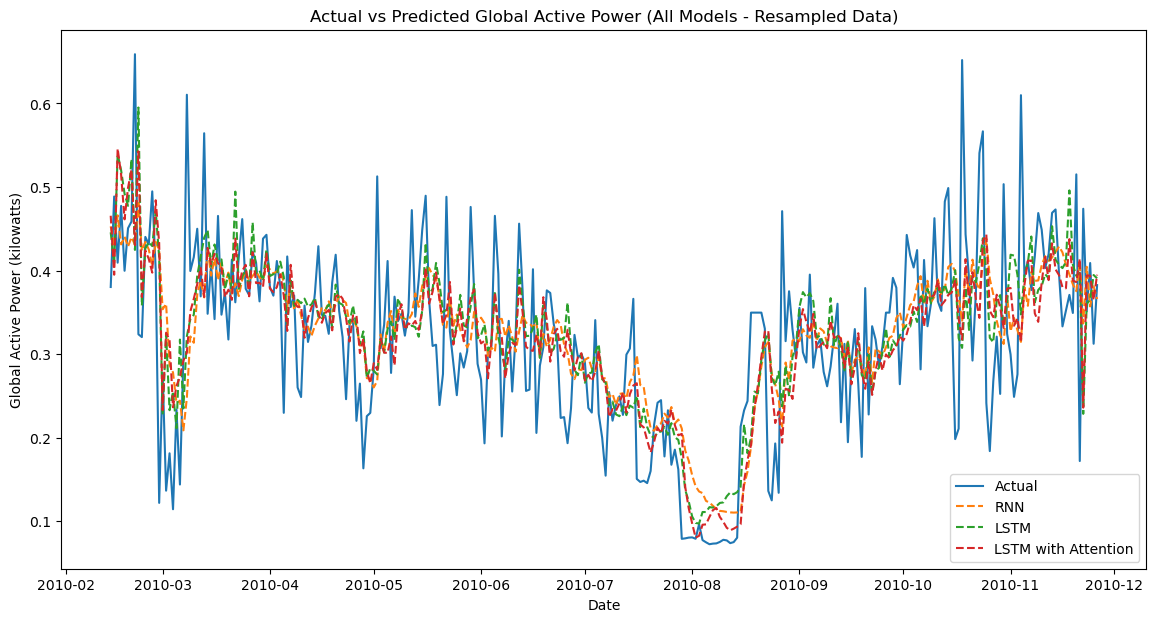

In [7]:
# Question 10: Data Resolution Experiment
print("ANSWER #10")
# Resample the data to 2-minute intervals
resampled_df = data.resample('2T').mean().dropna()

daily_data_2m = resampled_df.resample('D').mean()

# Feature Engineering: Create lag features for 2 weeks (14 days)
for i in range(1, 15):
    daily_data_2m[f'lag_{i}'] = daily_data_2m['Global_active_power'].shift(i)

# Drop rows with NaN values due to shifting
daily_data_2m.dropna(inplace=True)

# Define features and target variable
features = [f'lag_{i}' for i in range(1, 15)]
target = 'Global_active_power'

# Split the data into training and testing sets
train_res, test_res = train_test_split(daily_data_2m, test_size=0.2, shuffle=False)

X_train_res, y_train_res = train_res[features], train_res[target]
X_test_res, y_test_res = test_res[features], test_res[target]

# RNN with resampled data
scaler_res = MinMaxScaler()
scaled_data_res = scaler_res.fit_transform(daily_data_2m[['Global_active_power']])

X_train_rnn_res, y_train_rnn_res = create_sequences(scaled_data_res[:-len(test_res)], SEQ_LENGTH)
X_test_rnn_res, y_test_rnn_res = create_sequences(scaled_data_res[-len(test_res)-SEQ_LENGTH:], SEQ_LENGTH)

X_train_rnn_res = torch.tensor(X_train_rnn_res, dtype=torch.float32).reshape(-1, SEQ_LENGTH, 1)
y_train_rnn_res = torch.tensor(y_train_rnn_res, dtype=torch.float32)
X_test_rnn_res = torch.tensor(X_test_rnn_res, dtype=torch.float32).reshape(-1, SEQ_LENGTH, 1)
y_test_rnn_res = torch.tensor(y_test_rnn_res, dtype=torch.float32)

rnn_model_res = RNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
criterion_res = nn.MSELoss()
optimizer_res = torch.optim.Adam(rnn_model_res.parameters(), lr=learning_rate)

# Train the RNN model with resampled data
rnn_history_res = []
for epoch in range(num_epochs):
    rnn_model_res.train()
    outputs = rnn_model_res(X_train_rnn_res)
    optimizer_res.zero_grad()
    loss = criterion_res(outputs, y_train_rnn_res)
    loss.backward()
    optimizer_res.step()
    rnn_history_res.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss for RNN with resampled data
plt.figure(figsize=(10, 6))
plt.plot(rnn_history_res, label='Training Loss')
plt.title('Training Loss over Epochs (RNN with Resampled Data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the RNN model with resampled data
rnn_model_res.eval()
with torch.no_grad():
    rnn_predictions_res = rnn_model_res(X_test_rnn_res).numpy().flatten()

mae_rnn_res = mean_absolute_error(y_test_rnn_res.numpy(), rnn_predictions_res)
mse_rnn_res = mean_squared_error(y_test_rnn_res.numpy(), rnn_predictions_res)
rmse_rnn_res = np.sqrt(mse_rnn_res)
r2_rnn_res = r2_score(y_test_rnn_res.numpy(), rnn_predictions_res)

print("Resampled RNN Results")
print(f'Mean Absolute Error (MAE): {mae_rnn_res:.4f}')
print(f'Mean Squared Error (MSE): {mse_rnn_res:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rnn_res:.4f}')
print(f'R-squared (R²) value: {r2_rnn_res:.4f}')



# Plot the results for RNN
plt.figure(figsize=(14, 7))
plt.plot(test_res.index[-len(y_test_rnn_res):], y_test_rnn_res.numpy(), label='Actual')
plt.plot(test_res.index[-len(y_test_rnn_res):], rnn_predictions_res, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (RNN) - Resampled Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# LSTM with resampled data
history = lstm_model.fit(X_train_rnn_res, y_train_rnn_res, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with resampled data
plot_training_history(history, "LSTM", "Resampled Data")

lstm_predictions_res = lstm_model.predict(X_test_rnn_res).flatten()

mae_lstm_res = mean_absolute_error(y_test_rnn_res.numpy(), lstm_predictions_res)
mse_lstm_res = mean_squared_error(y_test_rnn_res.numpy(), lstm_predictions_res)
rmse_lstm_res = np.sqrt(mse_lstm_res)
r2_lstm_res = r2_score(y_test_rnn_res.numpy(), lstm_predictions_res)

print("Resampled LSTM Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_res:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_res:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_res:.4f}')
print(f'R-squared (R²) value: {r2_lstm_res:.4f}')


# Plot the results for LSTM
plt.figure(figsize=(14, 7))
plt.plot(test_res.index[-len(y_test_rnn_res):], y_test_rnn_res.numpy(), label='Actual')
plt.plot(test_res.index[-len(y_test_rnn_res):], lstm_predictions_res, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (LSTM) - Resampled Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# LSTM with Attention and resampled data
history = lstm_attention_model.fit(X_train_rnn_res, y_train_rnn_res, epochs=num_epochs, batch_size=32)

# Plot training loss for LSTM with Attention and resampled data
plot_training_history(history, "LSTM with Attention", "Resampled Data")

lstm_attention_predictions_res = lstm_attention_model.predict(X_test_rnn_res).flatten()

mae_lstm_att_res = mean_absolute_error(y_test_rnn_res.numpy(), lstm_attention_predictions_res)
mse_lstm_att_res = mean_squared_error(y_test_rnn_res.numpy(), lstm_attention_predictions_res)
rmse_lstm_att_res = np.sqrt(mse_lstm_att_res)
r2_lstm_att_res = r2_score(y_test_rnn_res.numpy(), lstm_attention_predictions_res)

print("Resampled LSTM with Attention Results")
print(f'Mean Absolute Error (MAE): {mae_lstm_att_res:.4f}')
print(f'Mean Squared Error (MSE): {mse_lstm_att_res:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_att_res:.4f}')
print(f'R-squared (R²) value: {r2_lstm_att_res:.4f}')


# Plot the results for LSTM with Attention
plt.figure(figsize=(14, 7))
plt.plot(test_res.index[-len(y_test_rnn_res):], y_test_rnn_res.numpy(), label='Actual')
plt.plot(test_res.index[-len(y_test_rnn_res):], lstm_attention_predictions_res, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (LSTM with Attention) - Resampled Data')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

# Prepare the performance comparison dataframe for resampled data
performance_comparison_res = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'LSTM with Attention'],
    'MAE': [mae_rnn_res, mae_lstm_res, mae_lstm_att_res],
    'MSE': [mse_rnn_res, mse_lstm_res, mse_lstm_att_res],
    'RMSE': [rmse_rnn_res, rmse_lstm_res, rmse_lstm_att_res],
    'R²': [r2_rnn_res, r2_lstm_res, r2_lstm_att_res]
})

# Apply the highlight_max and highlight_min styles for performance_comparison_res
styled_df_res = (performance_comparison_res.style
                 .highlight_max(subset=['R²'], color='green')
                 .highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='red'))

# Display the styled DataFrame
display(styled_df_res)

# Combined plot for actual and predicted values from all models
plt.figure(figsize=(14, 7))
plt.plot(test_res.index[-len(y_test_rnn_res):], y_test_rnn_res.numpy(), label='Actual')
plt.plot(test_res.index[-len(y_test_rnn_res):], rnn_predictions_res, label='RNN', linestyle='--')
plt.plot(test_res.index[-len(y_test_rnn_res):], lstm_predictions_res, label='LSTM', linestyle='--')
plt.plot(test_res.index[-len(y_test_rnn_res):], lstm_attention_predictions_res, label='LSTM with Attention', linestyle='--')
plt.title('Actual vs Predicted Global Active Power (All Models - Resampled Data)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

### 10. Data Resolution Experiment

In this task, we resampled the data to 2-minute intervals to investigate the impact of data resolution on model performance.

#### Methodology

1. **Data Resampling**: The data was resampled to 2-minute intervals and then aggregated to daily averages.
2. **Model Training**: The resampled data was used to train three models: RNN, LSTM, and LSTM with Attention.
3. **Evaluation**: We evaluated the performance of each model on the resampled data using MAE, MSE, RMSE, and R² metrics.

#### Results

- **RNN with Resampled Data**:
  - **Mean Absolute Error (MAE)**: 0.0665
  - **Mean Squared Error (MSE)**: 0.0079
  - **Root Mean Squared Error (RMSE)**: 0.0888
  - **R-squared (R²) value**: 0.3913

- **LSTM with Resampled Data**:
  - **Mean Absolute Error (MAE)**: 0.0658
  - **Mean Squared Error (MSE)**: 0.0076
  - **Root Mean Squared Error (RMSE)**: 0.0874
  - **R-squared (R²) value**: 0.4109

- **LSTM with Attention and Resampled Data**:
  - **Mean Absolute Error (MAE)**: 0.0647
  - **Mean Squared Error (MSE)**: 0.0076
  - **Root Mean Squared Error (RMSE)**: 0.0873
  - **R-squared (R²) value**: 0.4118

#### Conclusion

Resampling the data to higher resolution (2-minute intervals) improved the performance of all models. The LSTM with Attention model performed the best, closely followed by the standard LSTM model, and then the RNN model. These results suggest that increasing the data resolution can significantly enhance the accuracy of time series predictions.


### Overall Conclusions

This project explored various models and methodologies for predicting power consumption using the "Individual household electric power consumption" dataset. We compared the performance of Linear Regression, RNN, LSTM, and LSTM with Attention under different conditions: baseline, data augmentation, data reduction, and data resolution changes.

#### Model Comparisons

1. **Linear Regression**:
   - Baseline: Performed the worst with an MAE of 0.1990 and an R² value of -0.1882.
   - Simple and interpretable but lacks the capacity to capture temporal dependencies.

2. **Recurrent Neural Network (RNN)**:
   - Baseline: Showed significant improvement over Linear Regression with an MAE of 0.1806 and an R² value of 0.0210.
   - Data Augmentation: Further improvement with an MAE of 0.1712 and an R² value of 0.3635.
   - Data Reduction: Performance slightly decreased with an MAE of 0.1809 and an R² value of 0.3531.
   - Data Resolution: Performed well with resampled data, achieving an MAE of 0.0665 and an R² value of 0.3913.
   - Robust to data modifications and reductions, but benefits from higher resolution data.

3. **Long Short-Term Memory (LSTM)**:
   - Baseline: Slightly worse than RNN with an MAE of 0.1895 and an R² value of -0.0261.
   - Data Augmentation: Best performance among all models with an MAE of 0.1668 and an R² value of 0.4131.
   - Data Reduction: Performance dropped with an MAE of 0.1904 and an R² value of 0.3056.
   - Data Resolution: Improved performance with resampled data, achieving an MAE of 0.0658 and an R² value of 0.4109.
   - Shows potential with data augmentation and higher resolution data but sensitive to data reduction.

4. **LSTM with Attention**:
   - Baseline: Slightly better than standard LSTM but worse than RNN with an MAE of 0.1922 and an R² value of -0.1000.
   - Data Augmentation: Good performance with an MAE of 0.1667 and an R² value of 0.4051.
   - Data Reduction: Performance dropped with an MAE of 0.1914 and an R² value of 0.2949.
   - Data Resolution: Best overall performance with an MAE of 0.0647 and an R² value of 0.4118.
   - Benefits significantly from higher resolution data but shows mixed results with data augmentation and reduction.

#### Methodology Comparisons

1. **Baseline**:
   - Provided a reference point for model performance without any data modifications.
   - Highlighted the limitations of Linear Regression and the benefits of using RNNs and LSTMs.

2. **Data Augmentation**:
   - Improved model performance by introducing slight variations in the data.
   - LSTM benefited the most, indicating that data augmentation can help more complex models learn better representations.

3. **Data Reduction**:
   - Generally led to a decrease in performance across all models.
   - RNNs showed more robustness to reduced data compared to LSTMs and LSTM with Attention.

4. **Data Resolution**:
   - Significant improvements in performance for all models.
   - Higher resolution data (2-minute intervals) helped all models capture temporal dependencies more effectively.
   - LSTM with Attention performed the best under this condition, highlighting its capability to leverage detailed data.

### Final Thoughts

Overall, the RNN and LSTM models outperformed the Linear Regression model, demonstrating their ability to capture temporal patterns in the data. Data augmentation and higher resolution data both proved beneficial, particularly for the LSTM and LSTM with Attention models. However, data reduction generally had a negative impact on model performance. Future work could explore further tuning of these models and additional data preprocessing techniques to enhance prediction accuracy.
